# 0. Dependencies
This notebook requires three dependencies to work properly, all three which are publicly available:
1. Jupyter kernel containing the python package dependencies below. The easiest way to install a functioning kernel is to follow the step-by-step explanation in notebook `0_resources.ipynb`.
2. Region sets which can be used to calculate FRIP. You can either supply your own (e.g. generate from peak calling on aggregate data from your samples, or previous experiments), or use the ENCODE SCREEN regions, which can be downloaded from `PUMATAC_dependencies` (see notebook `0_resources.ipynb`)
3. Aligned fragments files generated using either `PUMATAC` or `cellranger`.

In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

import pycisTopic
import glob
import os
import pybiomart as pbm
import pandas as pd
import pickle
from pycisTopic.qc import *
from IPython.display import Image, display
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import palettable
import pypumatac as pum  # this loads the main functions needed in this notebook.
import pprint as pp


%matplotlib inline
%load_ext lab_black

# 1. Run basic cisTopic analysis

Define which pipeline was used to generate your output using the variable `pipeline`. This can be either `PUMATAC`, `cellranger-atac` or `cellranger-arc`.

In [2]:
# pipeline = "PUMATAC"
# pipeline = "cellranger-atac"
pipeline = "cellranger-arc"

For `PUMATAC`, simply list the `PUMATAC` output directory, which will contain subdirectories for all samples.  
For `cellranger-atac` and `cellranger-arc`, list a master directory which contains the cellranger output directories. i.e. if you have 5 cellranger runs, put the output directories in one master directory, and redirect `output_dir` there.

In [3]:
output_dir = "cellranger_arc_output"

In [4]:
pum.list_files(output_dir, maxlevel=1)

cellranger_arc_output/
    TEW__ebb273__b33e6f__Multiome_Liver_CTRL_NSTprotocol
    TEW__18d159__fe5107__Multiome_Liver_CCL4
    TEW__872466__dedf23__Multiome_Liver_CTRL1
    TEW__8e1858__1371a9__Multiome_Liver_TBX3KO2
    TEW__043783__523d9c__Multiome_Liver_10xprotocol
    TEW__72f3ec__1371a9__Multiome_Liver_TBX3KO1
    TEW__95843a__0f8200__Multiome_Liver_CTRL2
    TEW__703a9e__28aa75__Multiome_Liver_CTRL


### Find paths to fragments
The following list comprehension should find fragments files in your `output_dir`.

In [5]:
if pipeline == "PUMATAC":
    fragments_paths_dict = {
        os.path.basename(x).split(".fragments.tsv.gz")[0]: x
        for x in glob.glob(f"{output_dir}/data/fragments/*fragments.tsv.gz")
    }

elif pipeline == "cellranger-arc" or pipeline == "cellranger-atac":
    fragments_paths_dict = {
        x.split("/")[1]: x
        for x in glob.glob(f"{output_dir}/*/outs/atac_fragments.tsv.gz")
    }

fragments_paths_dict

{'TEW__ebb273__b33e6f__Multiome_Liver_CTRL_NSTprotocol': 'cellranger_arc_output/TEW__ebb273__b33e6f__Multiome_Liver_CTRL_NSTprotocol/outs/atac_fragments.tsv.gz',
 'TEW__18d159__fe5107__Multiome_Liver_CCL4': 'cellranger_arc_output/TEW__18d159__fe5107__Multiome_Liver_CCL4/outs/atac_fragments.tsv.gz',
 'TEW__872466__dedf23__Multiome_Liver_CTRL1': 'cellranger_arc_output/TEW__872466__dedf23__Multiome_Liver_CTRL1/outs/atac_fragments.tsv.gz',
 'TEW__8e1858__1371a9__Multiome_Liver_TBX3KO2': 'cellranger_arc_output/TEW__8e1858__1371a9__Multiome_Liver_TBX3KO2/outs/atac_fragments.tsv.gz',
 'TEW__043783__523d9c__Multiome_Liver_10xprotocol': 'cellranger_arc_output/TEW__043783__523d9c__Multiome_Liver_10xprotocol/outs/atac_fragments.tsv.gz',
 'TEW__72f3ec__1371a9__Multiome_Liver_TBX3KO1': 'cellranger_arc_output/TEW__72f3ec__1371a9__Multiome_Liver_TBX3KO1/outs/atac_fragments.tsv.gz',
 'TEW__95843a__0f8200__Multiome_Liver_CTRL2': 'cellranger_arc_output/TEW__95843a__0f8200__Multiome_Liver_CTRL2/outs/atac

### Define which genome should be used for each sample
Create a dummy `genome_dict` first which has `hg38` by default, then adjust where necessary (valid values for this notebook at `hg38` and `mm10`, if you work with other genomes, you can manually add gene annotation and regions as you please).

In [6]:
if pipeline == "PUMATAC":
    dummy_genome_dict = {
        os.path.basename(x).split(".fragments.tsv.gz")[0]: "hg38"
        for x in glob.glob(f"{output_dir}/data/fragments/*fragments.tsv.gz")
    }
elif pipeline == "cellranger-arc" or pipeline == "cellranger-atac":
    dummy_genome_dict = {
        x.split("/")[1]: "mm10"
        for x in glob.glob(f"{output_dir}/*/outs/atac_fragments.tsv.gz")
    }

dummy_genome_dict

{'TEW__ebb273__b33e6f__Multiome_Liver_CTRL_NSTprotocol': 'mm10',
 'TEW__18d159__fe5107__Multiome_Liver_CCL4': 'mm10',
 'TEW__872466__dedf23__Multiome_Liver_CTRL1': 'mm10',
 'TEW__8e1858__1371a9__Multiome_Liver_TBX3KO2': 'mm10',
 'TEW__043783__523d9c__Multiome_Liver_10xprotocol': 'mm10',
 'TEW__72f3ec__1371a9__Multiome_Liver_TBX3KO1': 'mm10',
 'TEW__95843a__0f8200__Multiome_Liver_CTRL2': 'mm10',
 'TEW__703a9e__28aa75__Multiome_Liver_CTRL': 'mm10'}

You can then copy the `dumy_genome_dict` and manually set the real `genome_dict` here (replace `mm10` by `hg38` or `dm6` where necessary, or a custom genome if another species (see furhter):

In [7]:
genome_dict = {
    "TEW__ebb273__b33e6f__Multiome_Liver_CTRL_NSTprotocol": "mm10",
    "TEW__18d159__fe5107__Multiome_Liver_CCL4": "mm10",
    "TEW__872466__dedf23__Multiome_Liver_CTRL1": "mm10",
    "TEW__8e1858__1371a9__Multiome_Liver_TBX3KO2": "mm10",
    "TEW__043783__523d9c__Multiome_Liver_10xprotocol": "mm10",
    "TEW__72f3ec__1371a9__Multiome_Liver_TBX3KO1": "mm10",
    "TEW__95843a__0f8200__Multiome_Liver_CTRL2": "mm10",
    "TEW__703a9e__28aa75__Multiome_Liver_CTRL": "mm10",
}

Check if all samples are included:

In [8]:
if not set(genome_dict.keys()) == set(fragments_paths_dict.keys()):
    print("Warning, not all fragments files have genomes defined.")
else:
    print("Genomes defined for all fragments files!")

Genomes defined for all fragments files!


Create an inverse dictionary, listing the samples per genome.

In [9]:
inverse_genome_dict = {}
for sample, genome in genome_dict.items():
    if genome not in inverse_genome_dict:
        inverse_genome_dict[genome] = []
    inverse_genome_dict[genome].append(sample)

inverse_genome_dict

{'mm10': ['TEW__ebb273__b33e6f__Multiome_Liver_CTRL_NSTprotocol',
  'TEW__18d159__fe5107__Multiome_Liver_CCL4',
  'TEW__872466__dedf23__Multiome_Liver_CTRL1',
  'TEW__8e1858__1371a9__Multiome_Liver_TBX3KO2',
  'TEW__043783__523d9c__Multiome_Liver_10xprotocol',
  'TEW__72f3ec__1371a9__Multiome_Liver_TBX3KO1',
  'TEW__95843a__0f8200__Multiome_Liver_CTRL2',
  'TEW__703a9e__28aa75__Multiome_Liver_CTRL']}

### Define sample aliases
We can also define a `sample_alias_dict` which defines short hand names for each sample which will be used in the titles of plots.

In [10]:
sample_alias_dict = {x: x for x in fragments_paths_dict.keys()}
sample_alias_dict

{'TEW__ebb273__b33e6f__Multiome_Liver_CTRL_NSTprotocol': 'TEW__ebb273__b33e6f__Multiome_Liver_CTRL_NSTprotocol',
 'TEW__18d159__fe5107__Multiome_Liver_CCL4': 'TEW__18d159__fe5107__Multiome_Liver_CCL4',
 'TEW__872466__dedf23__Multiome_Liver_CTRL1': 'TEW__872466__dedf23__Multiome_Liver_CTRL1',
 'TEW__8e1858__1371a9__Multiome_Liver_TBX3KO2': 'TEW__8e1858__1371a9__Multiome_Liver_TBX3KO2',
 'TEW__043783__523d9c__Multiome_Liver_10xprotocol': 'TEW__043783__523d9c__Multiome_Liver_10xprotocol',
 'TEW__72f3ec__1371a9__Multiome_Liver_TBX3KO1': 'TEW__72f3ec__1371a9__Multiome_Liver_TBX3KO1',
 'TEW__95843a__0f8200__Multiome_Liver_CTRL2': 'TEW__95843a__0f8200__Multiome_Liver_CTRL2',
 'TEW__703a9e__28aa75__Multiome_Liver_CTRL': 'TEW__703a9e__28aa75__Multiome_Liver_CTRL'}

Then, manually adjust to your liking

In [11]:
sample_alias_dict = {
    "TEW__ebb273__b33e6f__Multiome_Liver_CTRL_NSTprotocol": "CTRL_NSTprotocol",
    "TEW__18d159__fe5107__Multiome_Liver_CCL4": "CCL4",
    "TEW__872466__dedf23__Multiome_Liver_CTRL1": "CTRL1",
    "TEW__8e1858__1371a9__Multiome_Liver_TBX3KO2": "TBX3KO2",
    "TEW__043783__523d9c__Multiome_Liver_10xprotocol": "10xprotocol",
    "TEW__72f3ec__1371a9__Multiome_Liver_TBX3KO1": "TBX3KO1",
    "TEW__95843a__0f8200__Multiome_Liver_CTRL2": "CTRL2",
    "TEW__703a9e__28aa75__Multiome_Liver_CTRL": "CTRL",
}

### Download a gene annotation from biomart
We need gene annotations to calculate TSS enrichment of fragments later. The following code will work for `hg38`, `hg37`, `mm10` and `dm6`.

In [12]:
annotation_dict = pum.download_genome_annotation(inverse_genome_dict)

Loading cached genome annotation mm10_annotation.tsv


The genome annotation looks like so:

In [13]:
annotation_dict["mm10"]

Chromosome      Start  Strand           Gene Transcript_type
58           chr2  154551776       1         Actl10  protein_coding
624          chrX   31117674       1      Btbd35f29  protein_coding
946          chr7   84915781       1        Olfr290  protein_coding
977          chrY   90839177      -1        Gm21748  protein_coding
1000         chr4  108719649       1  3110021N24Rik  protein_coding
...           ...        ...     ...            ...             ...
136372       chr6  134791334      -1         Dusp16  protein_coding
136373      chr14   51203391       1          Ear14  protein_coding
136374      chr14   51203689       1          Ear14  protein_coding
136378      chr12   85274286       1        Zc2hc1c  protein_coding
136380      chr12   85288591       1        Zc2hc1c  protein_coding

[54721 rows x 5 columns]

If you want to use your own custom genome annotation, you can write an annotation in this format in a file named  `{genome}_annotation.tsv` in the current working directory.

### Define which regions to use to calculate fraction of reads in peaks
Ideally this should be cluster consensus peaks called on each sample individually, but for rough QC purposes, the ENCODE SCREEN regions suffice.  
We host a copy of these regions for mm10 and hg38 here https://resources.aertslab.org/papers/PUMATAC/PUMATAC_dependencies/regions/. For dm6, you can use the cisTarget regions: https://resources.aertslab.org/cistarget/regions/dm6__regulatory_regions.regionid-location.bed

In [14]:
screen_path_dict = {
    os.path.basename(x).split("-")[0].split(".")[-1]: x
    for x in sorted(
        glob.glob("PUMATAC_dependencies/regions/V2*-rDHS-Unfiltered.blacklisted.bed")
    )
}
screen_path_dict

{'hg38': 'PUMATAC_dependencies/regions/V2.hg38-rDHS-Unfiltered.blacklisted.bed',
 'mm10': 'PUMATAC_dependencies/regions/V2.mm10-rDHS-Unfiltered.blacklisted.bed'}

In [15]:
if pipeline == "PUMATAC":
    regions_paths_dict = {
        os.path.basename(x).split(".fragments.tsv.gz")[0]: screen_path_dict[genome]
        for x in glob.glob(f"{output_dir}/data/fragments/*fragments.tsv.gz")
    }
elif pipeline == "cellranger-arc" or pipeline == "cellranger-atac":
    regions_paths_dict = {
        x.split("/")[1]: screen_path_dict[genome]
        for x in glob.glob(f"{output_dir}/*/outs/atac_fragments.tsv.gz")
    }

regions_paths_dict

{'TEW__ebb273__b33e6f__Multiome_Liver_CTRL_NSTprotocol': 'PUMATAC_dependencies/regions/V2.mm10-rDHS-Unfiltered.blacklisted.bed',
 'TEW__18d159__fe5107__Multiome_Liver_CCL4': 'PUMATAC_dependencies/regions/V2.mm10-rDHS-Unfiltered.blacklisted.bed',
 'TEW__872466__dedf23__Multiome_Liver_CTRL1': 'PUMATAC_dependencies/regions/V2.mm10-rDHS-Unfiltered.blacklisted.bed',
 'TEW__8e1858__1371a9__Multiome_Liver_TBX3KO2': 'PUMATAC_dependencies/regions/V2.mm10-rDHS-Unfiltered.blacklisted.bed',
 'TEW__043783__523d9c__Multiome_Liver_10xprotocol': 'PUMATAC_dependencies/regions/V2.mm10-rDHS-Unfiltered.blacklisted.bed',
 'TEW__72f3ec__1371a9__Multiome_Liver_TBX3KO1': 'PUMATAC_dependencies/regions/V2.mm10-rDHS-Unfiltered.blacklisted.bed',
 'TEW__95843a__0f8200__Multiome_Liver_CTRL2': 'PUMATAC_dependencies/regions/V2.mm10-rDHS-Unfiltered.blacklisted.bed',
 'TEW__703a9e__28aa75__Multiome_Liver_CTRL': 'PUMATAC_dependencies/regions/V2.mm10-rDHS-Unfiltered.blacklisted.bed'}

Again, if you want, you can manually edit this dictionary and substitute your own regions.

### Run cisTopic quality control tools
cisTopic has a suite of functions which calculate per-barcode quality metrics such as number of (unique) fragments, TSS enrichment, fraction of fragments in peaks and so on. Make a directory for cisTopic output:

In [16]:
cistopic_qc_out = "cistopic_qc_out"
if not os.path.exists(cistopic_qc_out):
    os.makedirs(cistopic_qc_out)

Determine which fragments files have already gone through cisTopic QC (in case you ran this notebook before)

In [17]:
fragments_sub_dict = {}
regions_sub_dict = {}
for sample in fragments_paths_dict.keys():
    metadata_file = os.path.join(cistopic_qc_out, sample + "__metadata_bc.pkl")
    print(f"Checking if {metadata_file} exist...")
    if os.path.exists(metadata_file):
        print("\tMetadata exists! Skipping...")
    else:
        fragments_sub_dict[sample] = fragments_paths_dict[sample]
        print("\tMetadata does not exist, adding to subdict to generate")

regions_sub_dict = {x: regions_paths_dict[x] for x in sorted(fragments_sub_dict.keys())}
regions_sub_dict

Checking if cistopic_qc_out/TEW__ebb273__b33e6f__Multiome_Liver_CTRL_NSTprotocol__metadata_bc.pkl exist...
	Metadata exists! Skipping...
Checking if cistopic_qc_out/TEW__18d159__fe5107__Multiome_Liver_CCL4__metadata_bc.pkl exist...
	Metadata exists! Skipping...
Checking if cistopic_qc_out/TEW__872466__dedf23__Multiome_Liver_CTRL1__metadata_bc.pkl exist...
	Metadata exists! Skipping...
Checking if cistopic_qc_out/TEW__8e1858__1371a9__Multiome_Liver_TBX3KO2__metadata_bc.pkl exist...
	Metadata exists! Skipping...
Checking if cistopic_qc_out/TEW__043783__523d9c__Multiome_Liver_10xprotocol__metadata_bc.pkl exist...
	Metadata exists! Skipping...
Checking if cistopic_qc_out/TEW__72f3ec__1371a9__Multiome_Liver_TBX3KO1__metadata_bc.pkl exist...
	Metadata exists! Skipping...
Checking if cistopic_qc_out/TEW__95843a__0f8200__Multiome_Liver_CTRL2__metadata_bc.pkl exist...
	Metadata exists! Skipping...
Checking if cistopic_qc_out/TEW__703a9e__28aa75__Multiome_Liver_CTRL__metadata_bc.pkl exist...
	Me

{}

Then execute cisTopic. The following code will run pycisTopic's QC toolbox on the fragments files provided above. It does so in blocks, where the number of samples per block is defined by `n_cores`. For example, if you have 64 samples, and you define `n_cores = 8`, the following loop will call ray 8 times and run 8 samples each time.

In [18]:
ray.shutdown()

In [19]:
n_cores = 8
for genome, samples in inverse_genome_dict.items():
    if regions_sub_dict != {}:
        samples_sub = list(set(regions_sub_dict.keys()).intersection(samples))
        blocks = [
            samples_sub[i : i + n_cores] for i in range(0, len(samples_sub), n_cores)
        ]
        pp.pprint(blocks)
        for samples_torun_in_block in blocks:
            fragments_sub_dict_block = {
                key: fragments_sub_dict[key] for key in samples_torun_in_block
            }
            regions_sub_dict_block = {
                key: regions_sub_dict[key] for key in samples_torun_in_block
            }
            print(f"Running samples {samples_torun_in_block} for genome {genome}")

            metadata_bc_dict, profile_data_dict = compute_qc_stats(
                fragments_dict=fragments_sub_dict_block,
                tss_annotation=annotation_dict[genome],
                stats=[
                    "barcode_rank_plot",
                    "duplicate_rate",
                    "insert_size_distribution",
                    "profile_tss",
                    "frip",
                ],
                label_list=None,
                path_to_regions=regions_sub_dict_block,
                n_cpu=n_cores,
                valid_bc=None,
                n_frag=10,
                n_bc=None,
                tss_flank_window=2000,
                tss_window=50,
                tss_minimum_signal_window=100,
                tss_rolling_window=10,
                # min_norm=0.2,
                remove_duplicates=True,
            )

            ray.shutdown()
            print(f"Done, writing files to {cistopic_qc_out}...")
            for sample in sorted(metadata_bc_dict.keys()):
                metadata_bc_dict[sample]["sample_id"] = sample
                metadata_bc_dict[sample].index = [
                    x + "___" + sample for x in list(metadata_bc_dict[sample].index)
                ]
                with open(
                    os.path.join(cistopic_qc_out, f"{sample}__metadata_bc.pkl"), "wb"
                ) as f:
                    pickle.dump(metadata_bc_dict[sample], f, protocol=4)

                with open(
                    os.path.join(cistopic_qc_out, f"{sample}__profile_data.pkl"), "wb"
                ) as f:
                    pickle.dump(profile_data_dict[sample], f, protocol=4)
    else:
        print("All samples already processed.")

All samples already processed.


We have now calculated various QC metrics and can proceed. `{sample}__metadata_bc.pkl` contains barcode level quality metrics such as number of fragments, TSS enrichment, ... per barcode. `__profile_data.pkl` contains the aggregate accessibility profile around TSS for every barcode.

In [20]:
sorted(os.listdir(cistopic_qc_out))

['TEW__043783__523d9c__Multiome_Liver_10xprotocol__metadata_bc.pkl',
 'TEW__043783__523d9c__Multiome_Liver_10xprotocol__profile_data.pkl',
 'TEW__18d159__fe5107__Multiome_Liver_CCL4__metadata_bc.pkl',
 'TEW__18d159__fe5107__Multiome_Liver_CCL4__profile_data.pkl',
 'TEW__703a9e__28aa75__Multiome_Liver_CTRL__metadata_bc.pkl',
 'TEW__703a9e__28aa75__Multiome_Liver_CTRL__profile_data.pkl',
 'TEW__72f3ec__1371a9__Multiome_Liver_TBX3KO1__metadata_bc.pkl',
 'TEW__72f3ec__1371a9__Multiome_Liver_TBX3KO1__profile_data.pkl',
 'TEW__872466__dedf23__Multiome_Liver_CTRL1__metadata_bc.pkl',
 'TEW__872466__dedf23__Multiome_Liver_CTRL1__profile_data.pkl',
 'TEW__8e1858__1371a9__Multiome_Liver_TBX3KO2__metadata_bc.pkl',
 'TEW__8e1858__1371a9__Multiome_Liver_TBX3KO2__profile_data.pkl',
 'TEW__95843a__0f8200__Multiome_Liver_CTRL2__metadata_bc.pkl',
 'TEW__95843a__0f8200__Multiome_Liver_CTRL2__profile_data.pkl',
 'TEW__ebb273__b33e6f__Multiome_Liver_CTRL_NSTprotocol__metadata_bc.pkl',
 'TEW__ebb273__b33e6f

### Filter cells from background noise
We then filter true cells (high TSS enrichment, and high number of unique fragments \[in peaks\]).

In [21]:
import seaborn as sns
import pprint as pp

Then, find the `__metadata_bc.pkl` files we just generated using cisTopic:

In [22]:
metadata_bc_pkl_path_dict = {
    os.path.basename(x).split("__metadata_bc.pkl")[0]: x
    for x in sorted(glob.glob(f"{cistopic_qc_out}/*metadata_bc.pkl"))
}
metadata_bc_pkl_path_dict

{'TEW__043783__523d9c__Multiome_Liver_10xprotocol': 'cistopic_qc_out/TEW__043783__523d9c__Multiome_Liver_10xprotocol__metadata_bc.pkl',
 'TEW__18d159__fe5107__Multiome_Liver_CCL4': 'cistopic_qc_out/TEW__18d159__fe5107__Multiome_Liver_CCL4__metadata_bc.pkl',
 'TEW__703a9e__28aa75__Multiome_Liver_CTRL': 'cistopic_qc_out/TEW__703a9e__28aa75__Multiome_Liver_CTRL__metadata_bc.pkl',
 'TEW__72f3ec__1371a9__Multiome_Liver_TBX3KO1': 'cistopic_qc_out/TEW__72f3ec__1371a9__Multiome_Liver_TBX3KO1__metadata_bc.pkl',
 'TEW__872466__dedf23__Multiome_Liver_CTRL1': 'cistopic_qc_out/TEW__872466__dedf23__Multiome_Liver_CTRL1__metadata_bc.pkl',
 'TEW__8e1858__1371a9__Multiome_Liver_TBX3KO2': 'cistopic_qc_out/TEW__8e1858__1371a9__Multiome_Liver_TBX3KO2__metadata_bc.pkl',
 'TEW__95843a__0f8200__Multiome_Liver_CTRL2': 'cistopic_qc_out/TEW__95843a__0f8200__Multiome_Liver_CTRL2__metadata_bc.pkl',
 'TEW__ebb273__b33e6f__Multiome_Liver_CTRL_NSTprotocol': 'cistopic_qc_out/TEW__ebb273__b33e6f__Multiome_Liver_CTRL_N

Concatenate to one large `metadata_bc_df_all`:

In [23]:
metadata_bc_df_all = pd.DataFrame()
for sample in metadata_bc_pkl_path_dict.keys():
    with open(metadata_bc_pkl_path_dict[sample], "rb") as fh:
        metadata_bc_df = pickle.load(fh)
        metadata_bc_df_all = pd.concat([metadata_bc_df_all, metadata_bc_df])
        print(f"Added {sample} metadata_bc_df")

Added TEW__043783__523d9c__Multiome_Liver_10xprotocol metadata_bc_df
Added TEW__18d159__fe5107__Multiome_Liver_CCL4 metadata_bc_df
Added TEW__703a9e__28aa75__Multiome_Liver_CTRL metadata_bc_df
Added TEW__72f3ec__1371a9__Multiome_Liver_TBX3KO1 metadata_bc_df
Added TEW__872466__dedf23__Multiome_Liver_CTRL1 metadata_bc_df
Added TEW__8e1858__1371a9__Multiome_Liver_TBX3KO2 metadata_bc_df
Added TEW__95843a__0f8200__Multiome_Liver_CTRL2 metadata_bc_df
Added TEW__ebb273__b33e6f__Multiome_Liver_CTRL_NSTprotocol metadata_bc_df


Calculate global maxima for variables, will be used to scale plots later. The idea is that plots for different samples will have the same axis limits so they can be compared directly visually.

In [24]:
max_dict = {}
min_dict = {}
for stat in metadata_bc_df_all.columns:
    max_dict[stat] = metadata_bc_df_all[stat].max()
    min_dict[stat] = metadata_bc_df_all[stat].min()

pp.pprint(min_dict)
pp.pprint(max_dict)

{'Dupl_nr_frag': 0,
 'Dupl_rate': 0.0,
 'FRIP': 0.0,
 'Log_total_nr_frag': 1.0413926851582251,
 'Log_unique_nr_frag': 1.0413926851582251,
 'TSS_enrichment': 0.0,
 'Total_nr_frag': 11,
 'Total_nr_frag_in_regions': 0,
 'Unique_nr_frag': 11,
 'Unique_nr_frag_in_regions': 0,
 'sample_id': 'TEW__043783__523d9c__Multiome_Liver_10xprotocol'}
{'Dupl_nr_frag': 731612,
 'Dupl_rate': 0.992442459635864,
 'FRIP': 1.0,
 'Log_total_nr_frag': 6.212197462510373,
 'Log_unique_nr_frag': 5.9534818283057005,
 'TSS_enrichment': 53.30709468888125,
 'Total_nr_frag': 1630037,
 'Total_nr_frag_in_regions': 645544,
 'Unique_nr_frag': 898425,
 'Unique_nr_frag_in_regions': 352172,
 'sample_id': 'TEW__ebb273__b33e6f__Multiome_Liver_CTRL_NSTprotocol'}


Now, we will apply Otsu's algorithm on all cells with more than `standard_min_x_val` fragments and a higher than `standard_min_y_val` TSS enrichment. For some samples, the standard minimum values might not produce good results, so these can be edited here if you want. For high quality samples, the standard values should work nicely. By default, Otsu's algorithm is applied to all cell barcodes with more than 100 barcodes and a TSS enrichment of 1. For most (high quality) samples, this works well. However, for some samples, especially samples with a high amount of low-quality barcodes, a higher threshold may be necessary. This can be done using the following dictionary:

In [25]:
samples_tech_dict = {x: "10x_atac" for x in fragments_paths_dict.keys()}
samples_tech_dict

{'TEW__ebb273__b33e6f__Multiome_Liver_CTRL_NSTprotocol': '10x_atac',
 'TEW__18d159__fe5107__Multiome_Liver_CCL4': '10x_atac',
 'TEW__872466__dedf23__Multiome_Liver_CTRL1': '10x_atac',
 'TEW__8e1858__1371a9__Multiome_Liver_TBX3KO2': '10x_atac',
 'TEW__043783__523d9c__Multiome_Liver_10xprotocol': '10x_atac',
 'TEW__72f3ec__1371a9__Multiome_Liver_TBX3KO1': '10x_atac',
 'TEW__95843a__0f8200__Multiome_Liver_CTRL2': '10x_atac',
 'TEW__703a9e__28aa75__Multiome_Liver_CTRL': '10x_atac'}

In [26]:
standard_min_x_val = 100
standard_min_y_val = 1
min_otsu_frags_dict = {}
min_otsu_tss_dict = {}
for metadata_bc_pkl_path in sorted(metadata_bc_pkl_path_dict.keys()):
    sample = metadata_bc_pkl_path.split("/")[-1].split("__metadata_bc.pkl")[0]
    tech = samples_tech_dict[sample]
    if tech == "ddseq":
        min_otsu_frags_dict[sample] = 300
    elif tech == "hydrop":
        min_otsu_frags_dict[sample] = 300
    else:
        min_otsu_frags_dict[sample] = standard_min_x_val

    if tech == "s3atac":
        min_otsu_tss_dict[sample] = 0
    else:
        min_otsu_tss_dict[sample] = standard_min_y_val

pp.pprint(min_otsu_frags_dict)
pp.pprint(min_otsu_tss_dict)

{'TEW__043783__523d9c__Multiome_Liver_10xprotocol': 100,
 'TEW__18d159__fe5107__Multiome_Liver_CCL4': 100,
 'TEW__703a9e__28aa75__Multiome_Liver_CTRL': 100,
 'TEW__72f3ec__1371a9__Multiome_Liver_TBX3KO1': 100,
 'TEW__872466__dedf23__Multiome_Liver_CTRL1': 100,
 'TEW__8e1858__1371a9__Multiome_Liver_TBX3KO2': 100,
 'TEW__95843a__0f8200__Multiome_Liver_CTRL2': 100,
 'TEW__ebb273__b33e6f__Multiome_Liver_CTRL_NSTprotocol': 100}
{'TEW__043783__523d9c__Multiome_Liver_10xprotocol': 1,
 'TEW__18d159__fe5107__Multiome_Liver_CCL4': 1,
 'TEW__703a9e__28aa75__Multiome_Liver_CTRL': 1,
 'TEW__72f3ec__1371a9__Multiome_Liver_TBX3KO1': 1,
 'TEW__872466__dedf23__Multiome_Liver_CTRL1': 1,
 'TEW__8e1858__1371a9__Multiome_Liver_TBX3KO2': 1,
 'TEW__95843a__0f8200__Multiome_Liver_CTRL2': 1,
 'TEW__ebb273__b33e6f__Multiome_Liver_CTRL_NSTprotocol': 1}


And here, we actually apply the algorithm in a loop:

In [27]:
kde = False

In [28]:
from IPython.display import Image, display

In [29]:
if not os.path.exists("plots_qc"):
    os.mkdir("plots_qc")
if not os.path.exists("selected_barcodes"):
    os.mkdir("selected_barcodes")

selected_barcodes/TEW__043783__523d9c__Multiome_Liver_10xprotocol_bc_passing_filters_otsu.pkl bc passing filters exists, skipping...


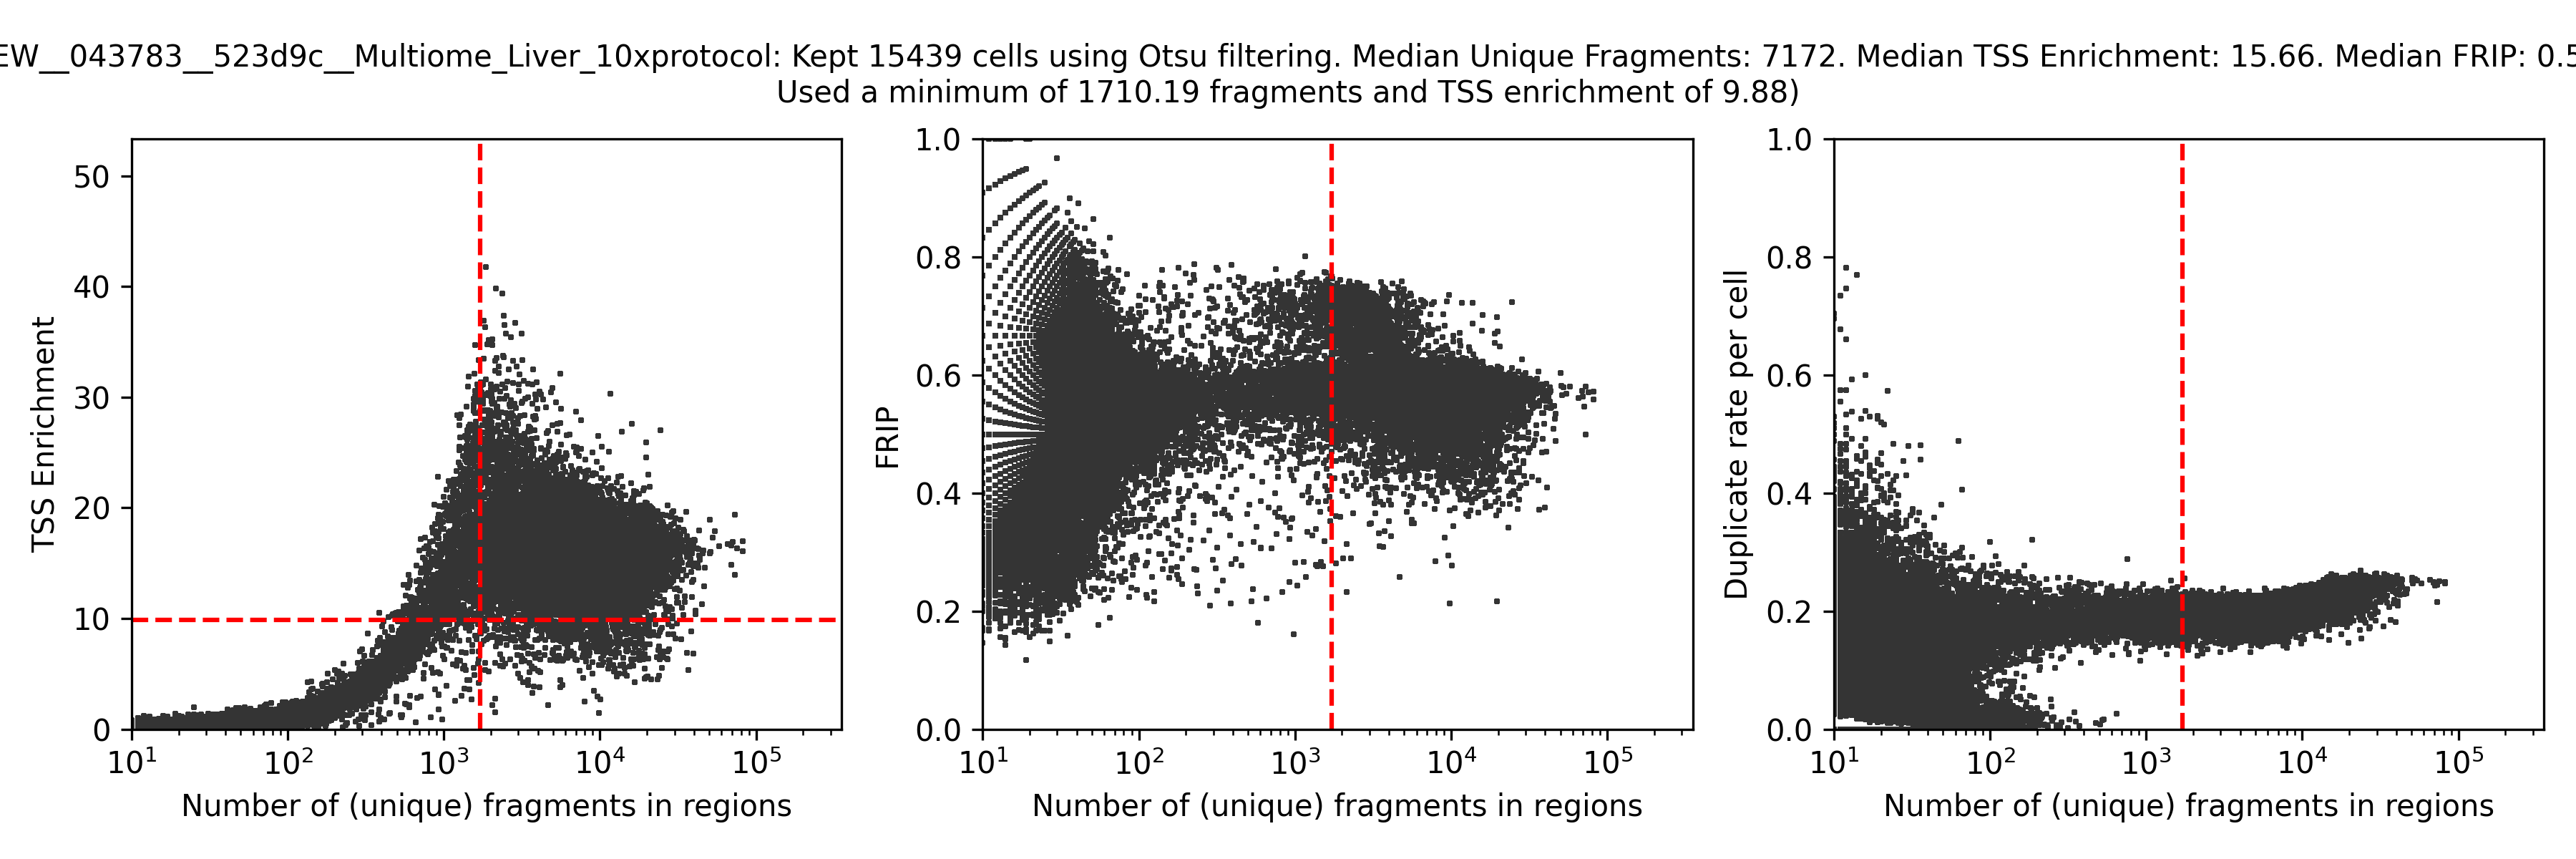

selected_barcodes/TEW__18d159__fe5107__Multiome_Liver_CCL4_bc_passing_filters_otsu.pkl bc passing filters exists, skipping...


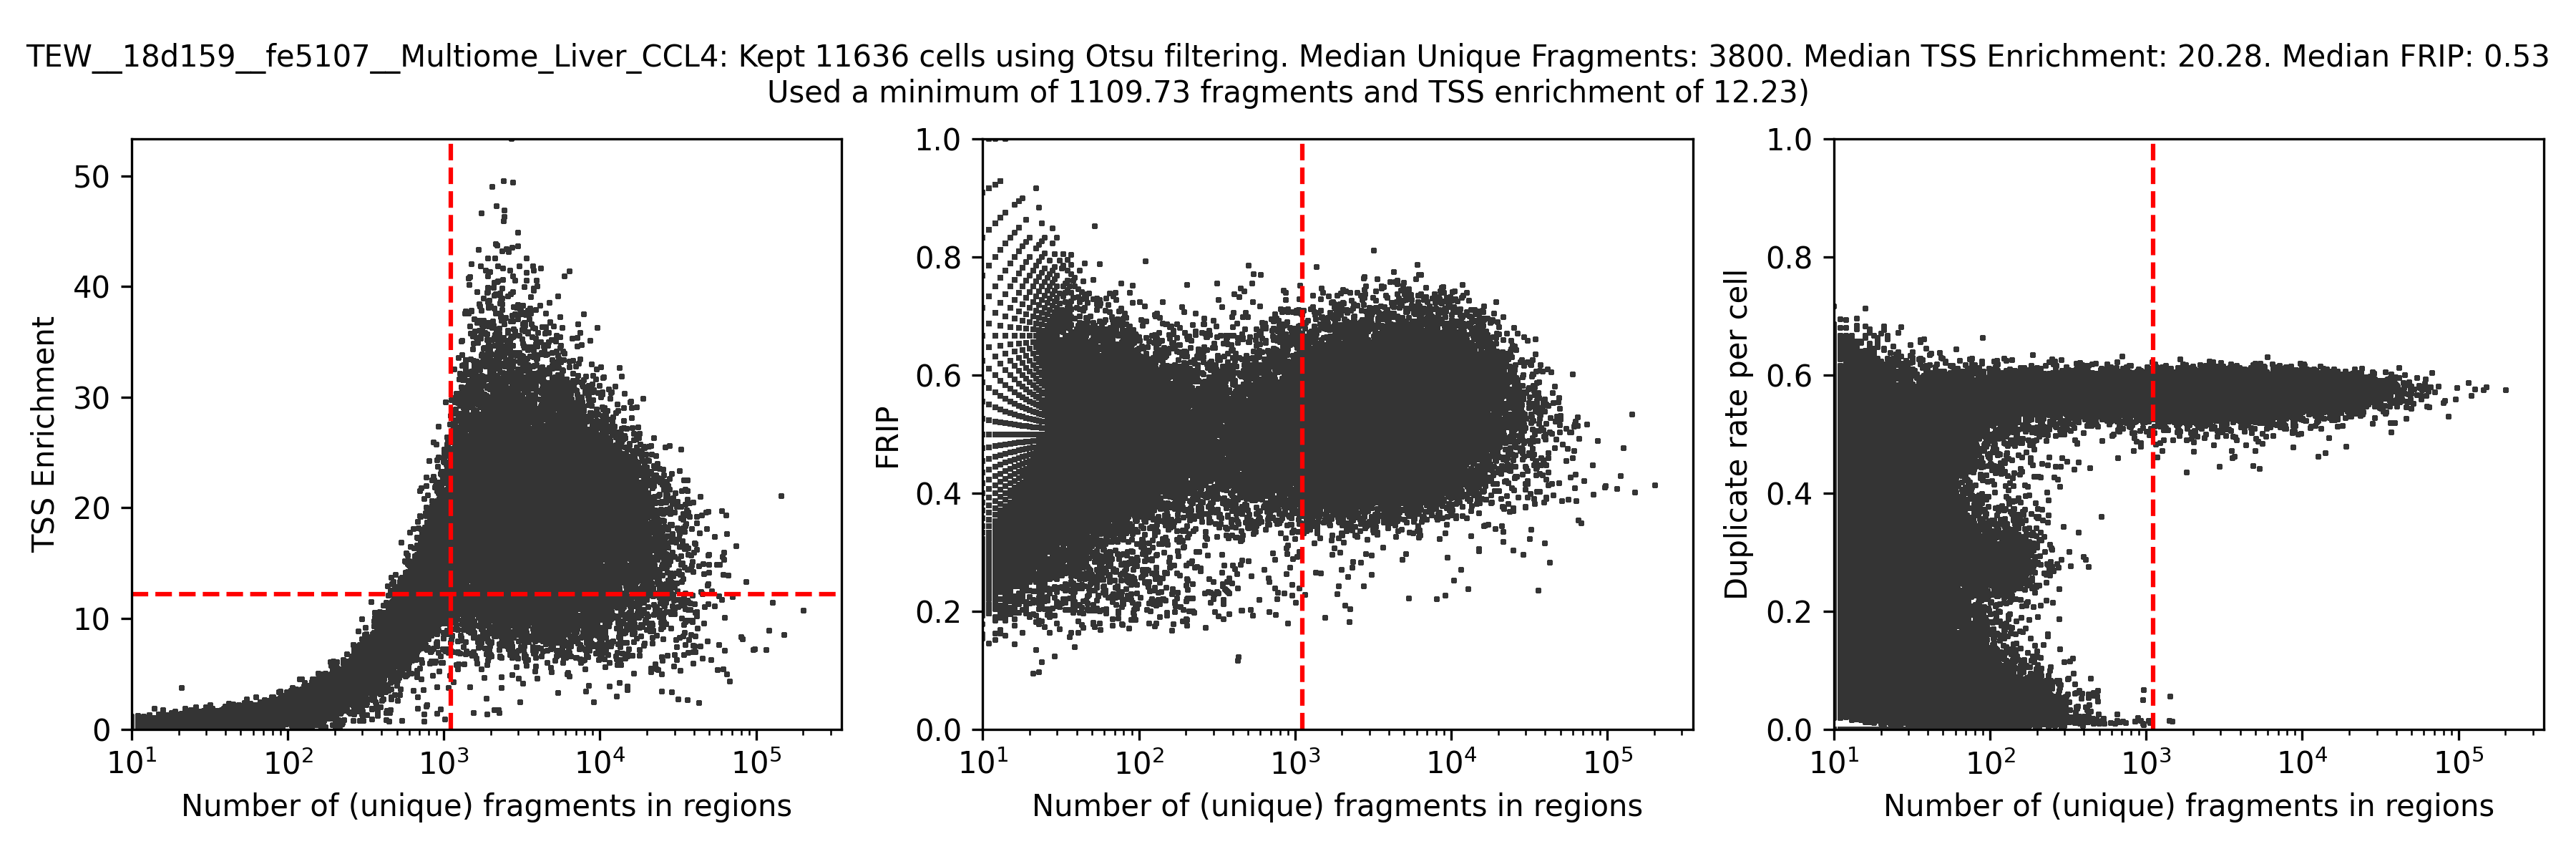

selected_barcodes/TEW__703a9e__28aa75__Multiome_Liver_CTRL_bc_passing_filters_otsu.pkl bc passing filters exists, skipping...


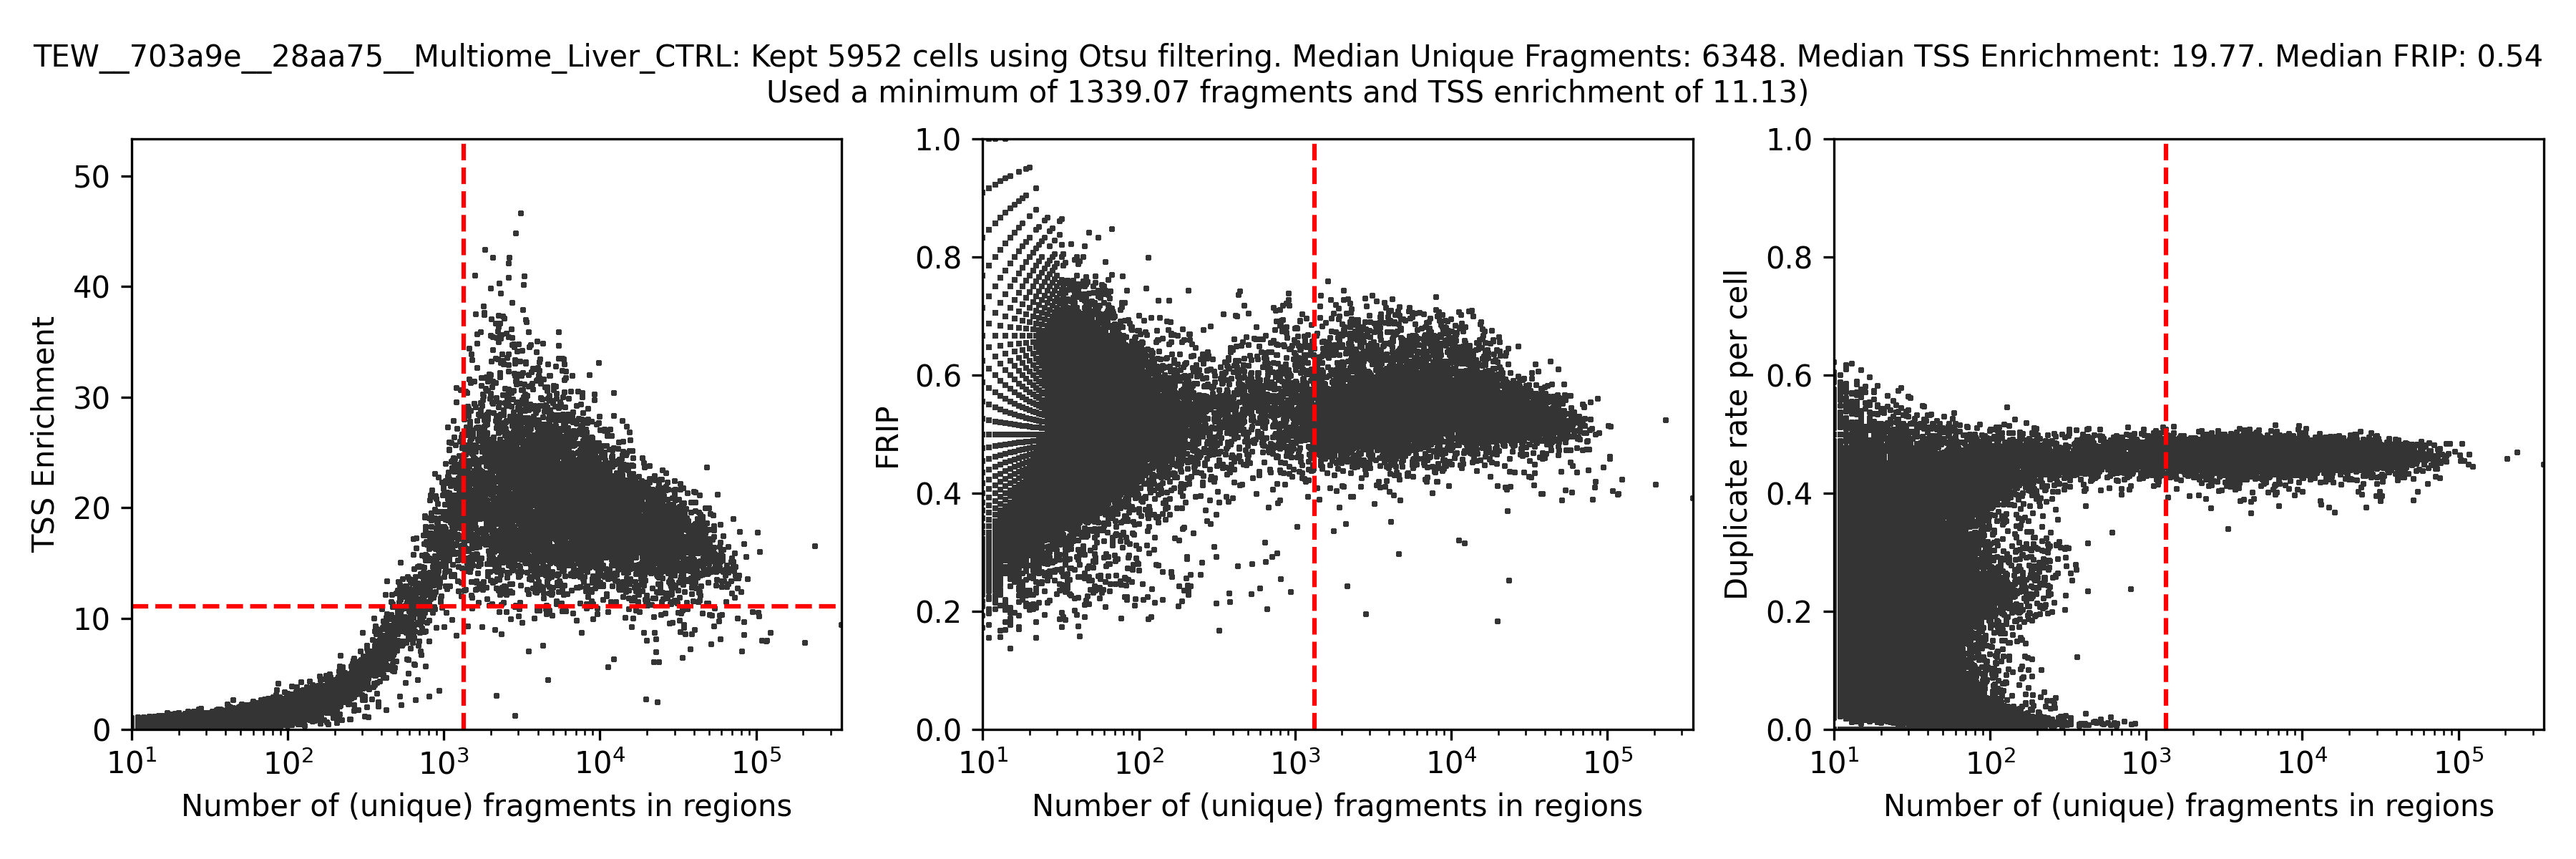

selected_barcodes/TEW__72f3ec__1371a9__Multiome_Liver_TBX3KO1_bc_passing_filters_otsu.pkl bc passing filters exists, skipping...


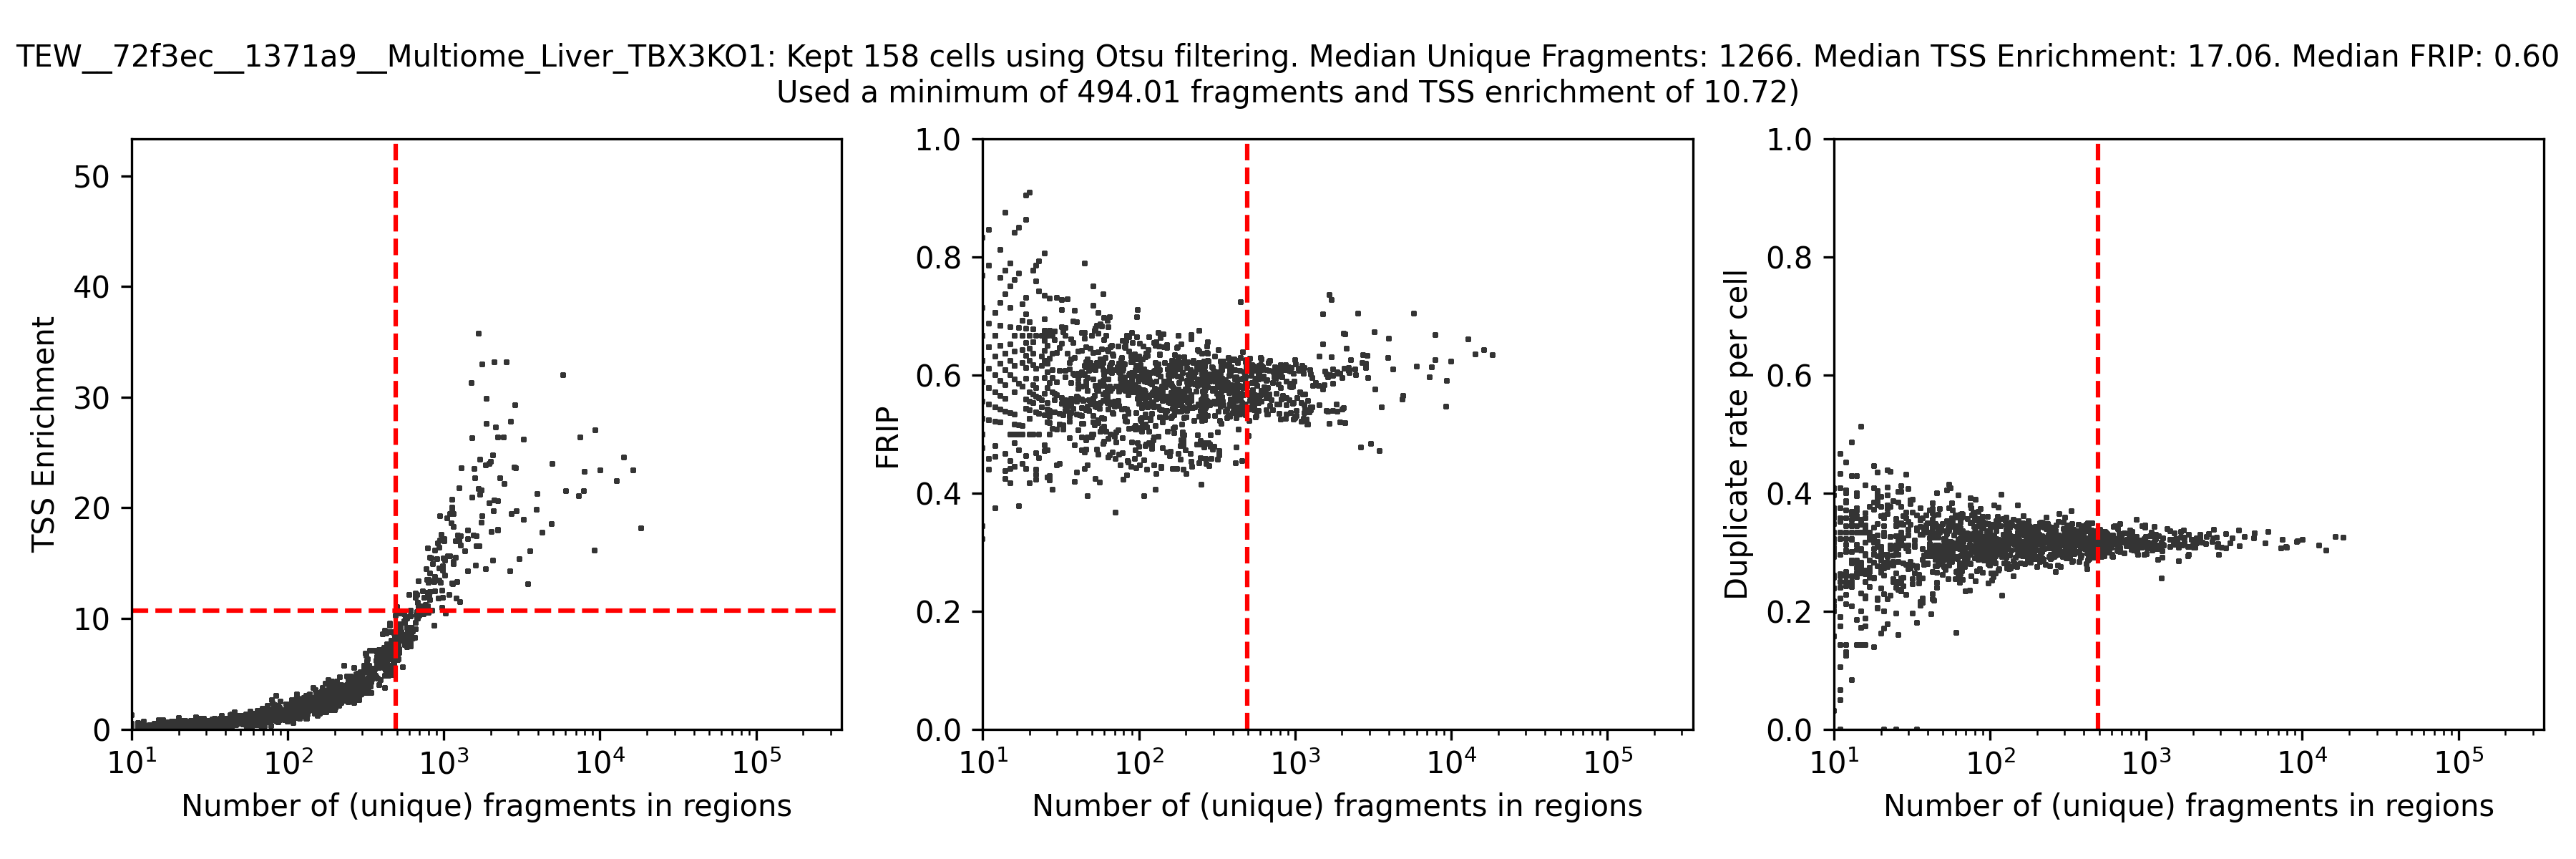

selected_barcodes/TEW__872466__dedf23__Multiome_Liver_CTRL1_bc_passing_filters_otsu.pkl bc passing filters exists, skipping...


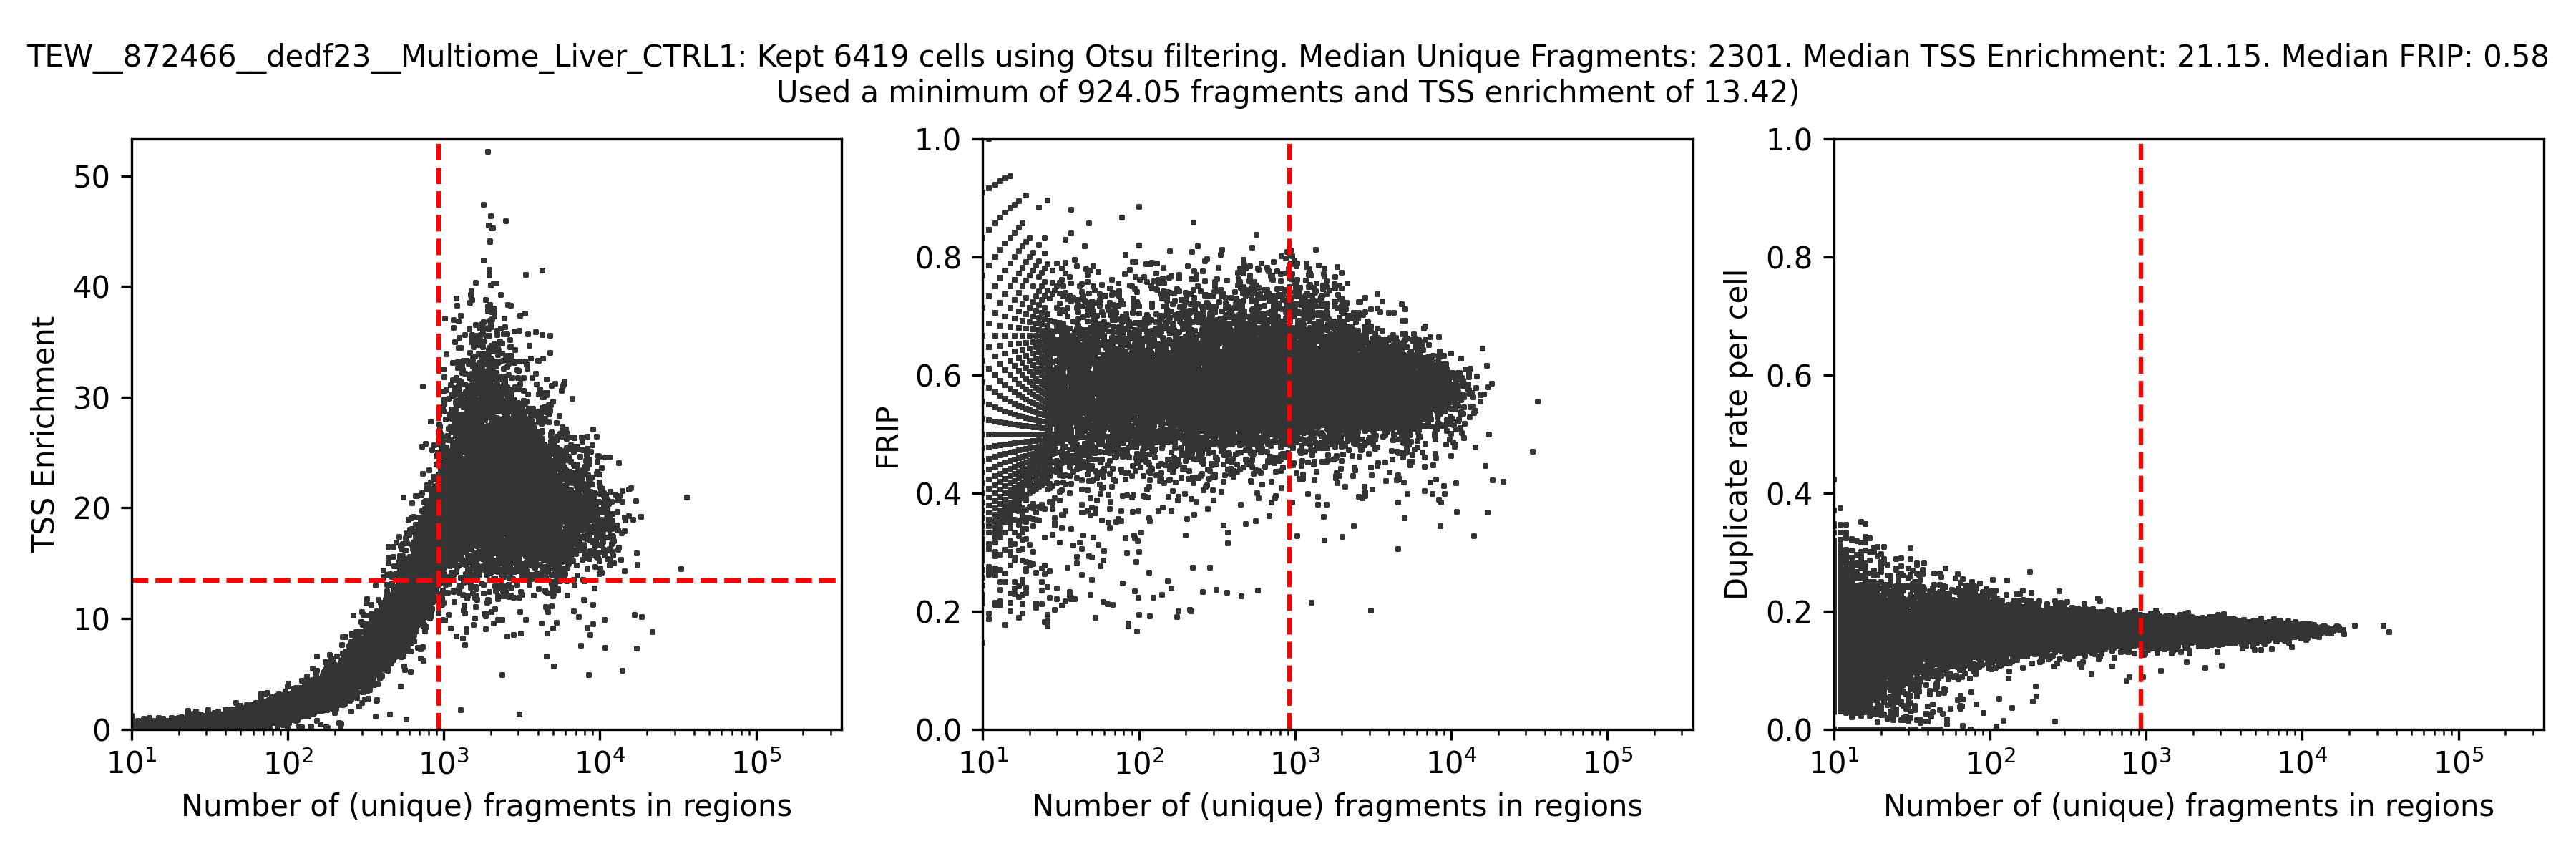

selected_barcodes/TEW__8e1858__1371a9__Multiome_Liver_TBX3KO2_bc_passing_filters_otsu.pkl bc passing filters exists, skipping...


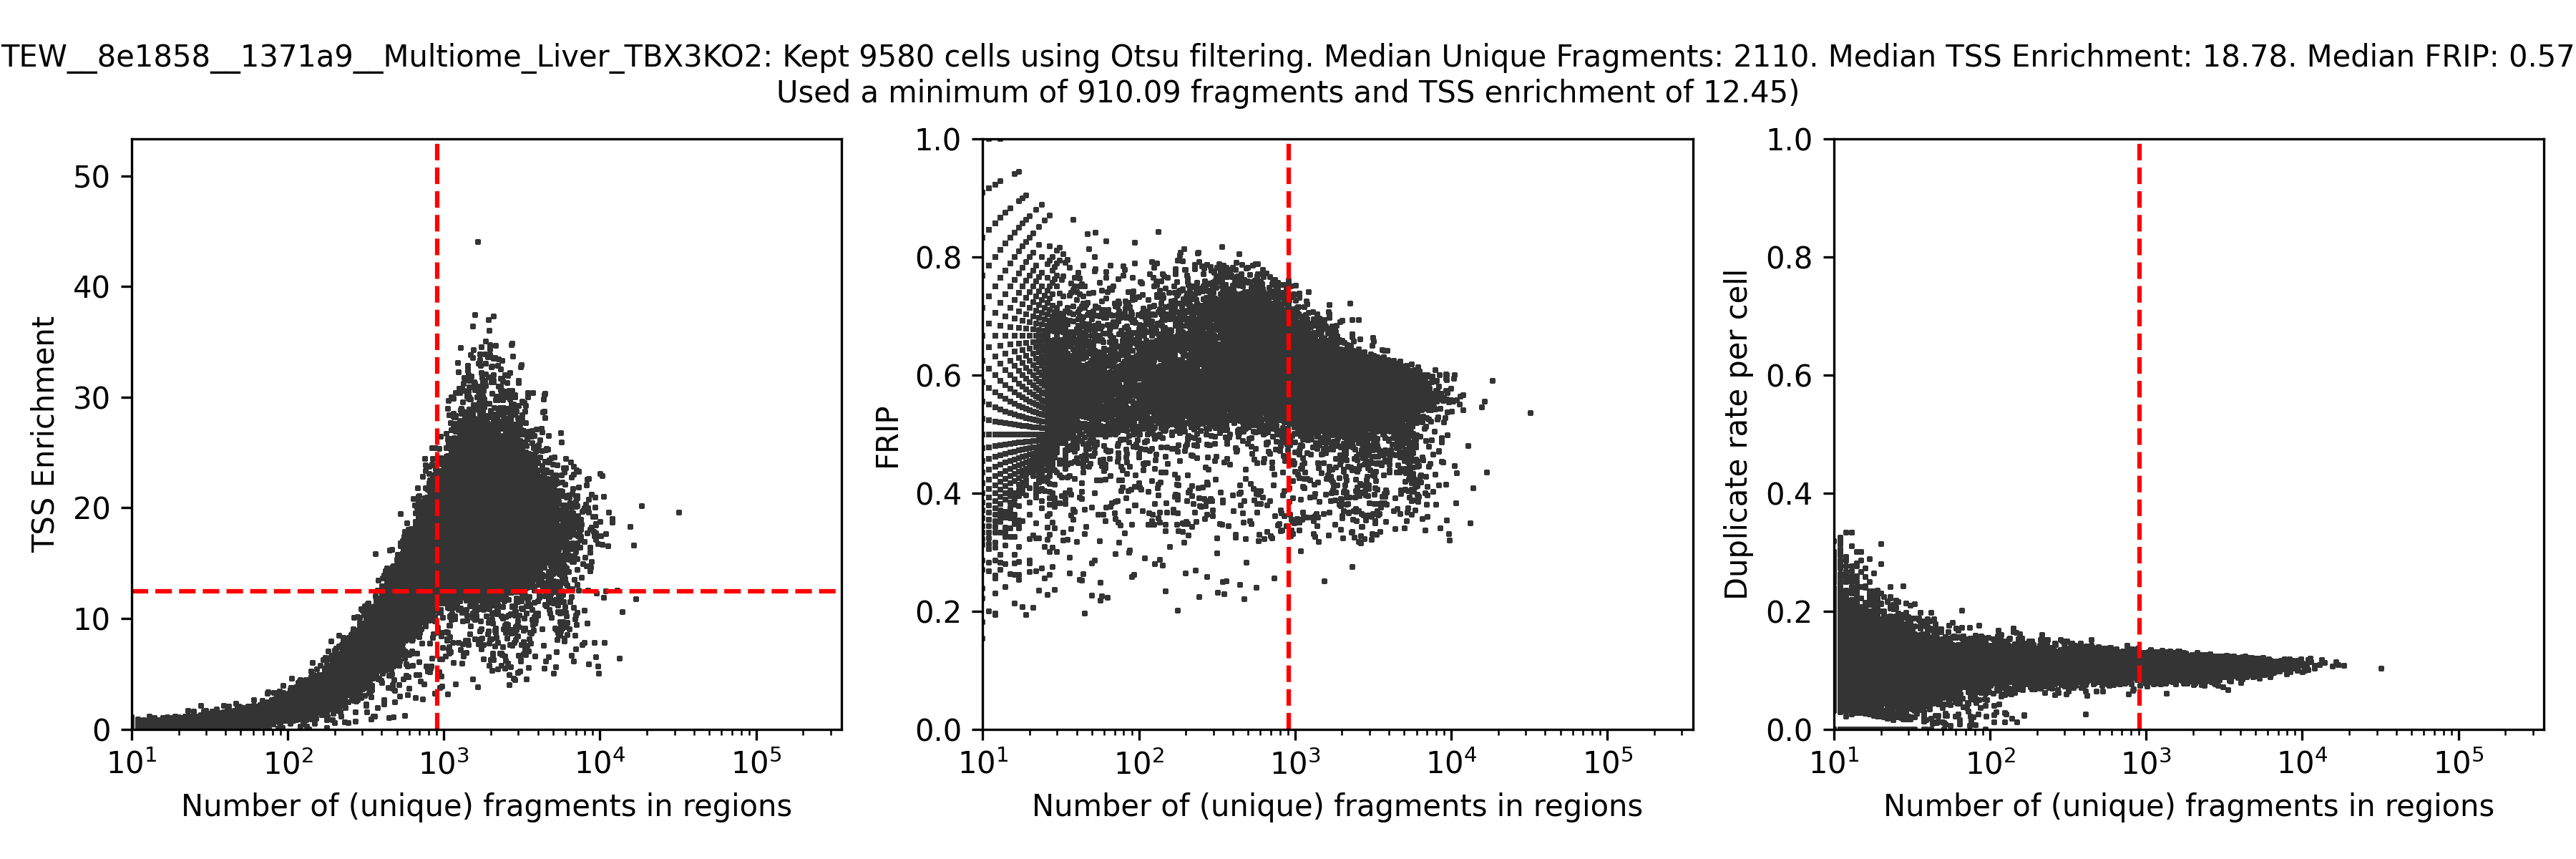

selected_barcodes/TEW__95843a__0f8200__Multiome_Liver_CTRL2_bc_passing_filters_otsu.pkl bc passing filters exists, skipping...


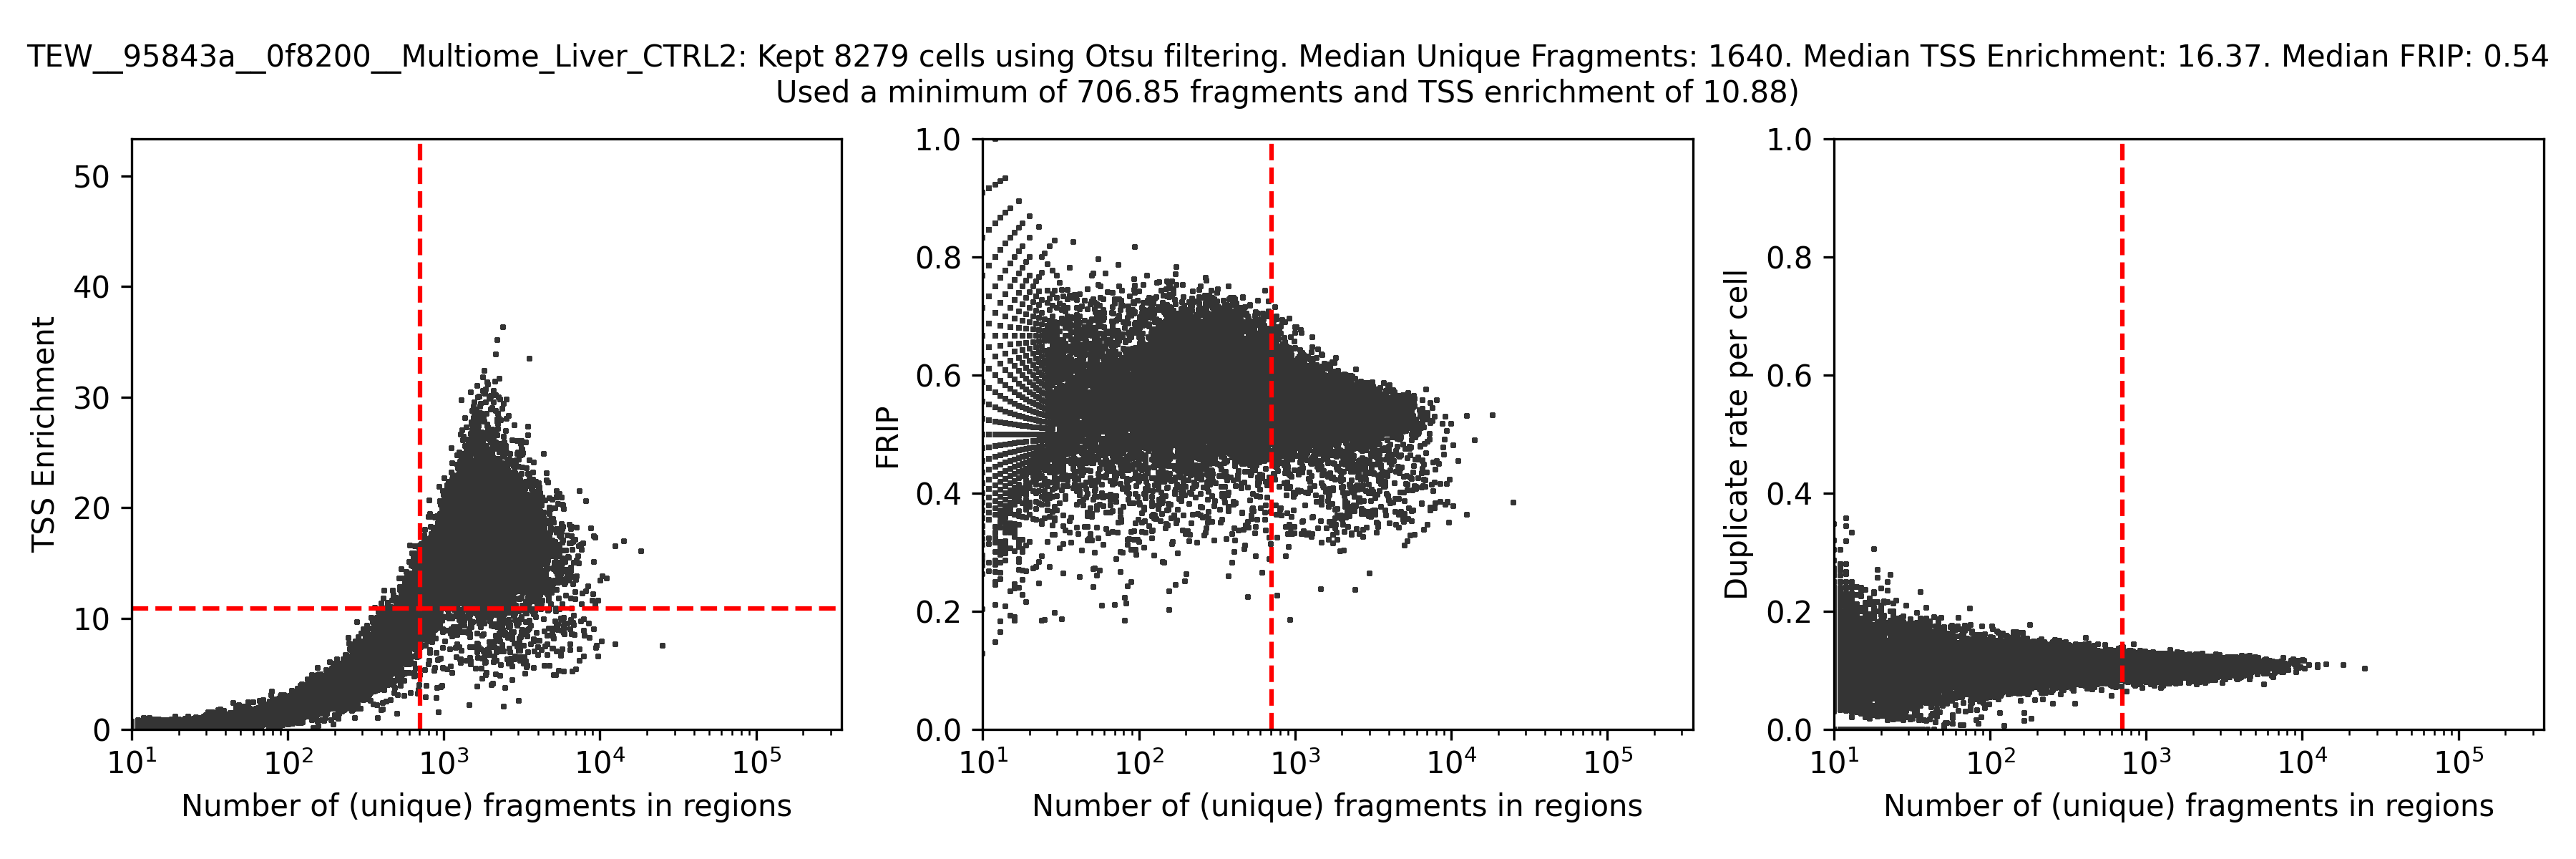

selected_barcodes/TEW__ebb273__b33e6f__Multiome_Liver_CTRL_NSTprotocol_bc_passing_filters_otsu.pkl bc passing filters exists, skipping...


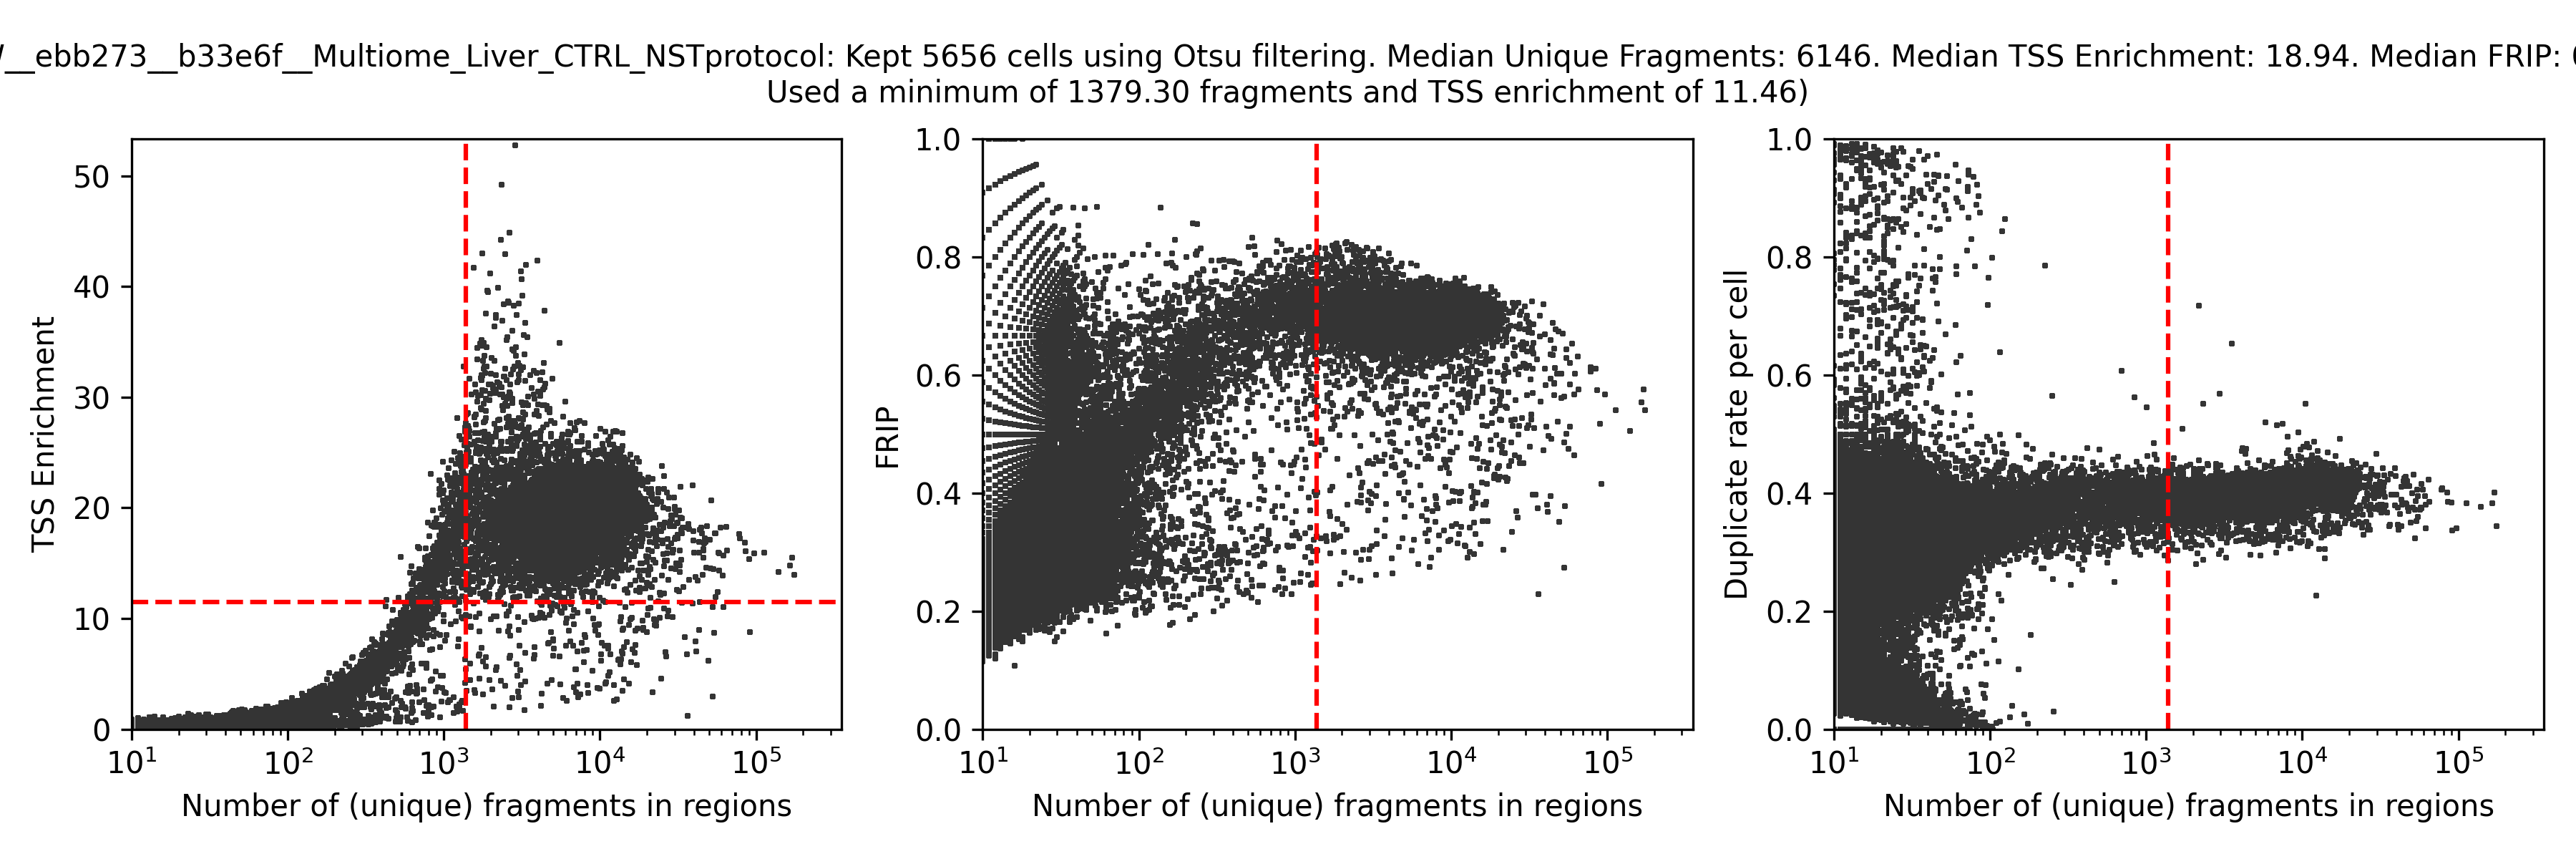

In [30]:
for sample in metadata_bc_pkl_path_dict.keys():
    pkl_path = f"selected_barcodes/{sample}_bc_passing_filters_otsu.pkl"
    if os.path.exists(pkl_path):
        print(f"{pkl_path} bc passing filters exists, skipping...")
        display(Image(filename=f"plots_qc/{sample}_qc_otsu.png"))

    else:
        print(f"{pkl_path} bc passing filters does not exist yet, generating...")
        print(f"\tLoading {metadata_bc_pkl_path_dict[sample]}")
        with open(metadata_bc_pkl_path_dict[sample], "rb") as fh:
            metadata_bc_df = pickle.load(fh)

        print(f"\tFiltering cells and generating QC plots.")
        if not sample in min_otsu_frags_dict.keys():
            print(
                f"\t{sample} not in minimum dict! Using standard value of {standard_min_x_val}"
            )
            min_x_val = standard_min_x_val
            min_y_val = standard_min_y_val
        else:
            min_x_val = min_otsu_frags_dict[sample]
            min_y_val = min_otsu_tss_dict[sample]

        bc_passing_filters, fig = pum.plot_qc(
            sample=sample,
            sample_alias=sample_alias_dict[sample],
            min_dict=min_dict,
            max_dict=max_dict,
            metadata_bc_df=metadata_bc_df,
            include_kde=kde,
            min_x_val=min_x_val,
            min_y_val=min_y_val,
        )

        plt.tight_layout()
        plt.savefig(f"plots_qc/{sample}_qc_otsu.png", dpi=300, facecolor="white")
        plt.show()
        plt.close()

        print(f"\tSaving...")
        with open(
            f"selected_barcodes/{sample}_bc_passing_filters_otsu.pkl", "wb"
        ) as fh:
            pickle.dump(bc_passing_filters, fh)
        fh.close()

        fh = open(f"selected_barcodes/{sample}_bc_passing_filters_otsu.txt", "w")
        for bc in list(bc_passing_filters):
            fh.write(bc + "\n")
        fh.close()

        metadata_bc_df.loc[bc_passing_filters].to_csv(
            f"selected_barcodes/{sample}_metadata_bc_df.tsv", sep="\t"
        )

# Plot profile data

In [31]:
profile_data_pkl_path_dict = {
    os.path.basename(x).split("__profile_data.pkl")[0]: x
    for x in sorted(glob.glob(f"{cistopic_qc_out}/*__profile_data.pkl"))
}
profile_data_pkl_path_dict

{'TEW__043783__523d9c__Multiome_Liver_10xprotocol': 'cistopic_qc_out/TEW__043783__523d9c__Multiome_Liver_10xprotocol__profile_data.pkl',
 'TEW__18d159__fe5107__Multiome_Liver_CCL4': 'cistopic_qc_out/TEW__18d159__fe5107__Multiome_Liver_CCL4__profile_data.pkl',
 'TEW__703a9e__28aa75__Multiome_Liver_CTRL': 'cistopic_qc_out/TEW__703a9e__28aa75__Multiome_Liver_CTRL__profile_data.pkl',
 'TEW__72f3ec__1371a9__Multiome_Liver_TBX3KO1': 'cistopic_qc_out/TEW__72f3ec__1371a9__Multiome_Liver_TBX3KO1__profile_data.pkl',
 'TEW__872466__dedf23__Multiome_Liver_CTRL1': 'cistopic_qc_out/TEW__872466__dedf23__Multiome_Liver_CTRL1__profile_data.pkl',
 'TEW__8e1858__1371a9__Multiome_Liver_TBX3KO2': 'cistopic_qc_out/TEW__8e1858__1371a9__Multiome_Liver_TBX3KO2__profile_data.pkl',
 'TEW__95843a__0f8200__Multiome_Liver_CTRL2': 'cistopic_qc_out/TEW__95843a__0f8200__Multiome_Liver_CTRL2__profile_data.pkl',
 'TEW__ebb273__b33e6f__Multiome_Liver_CTRL_NSTprotocol': 'cistopic_qc_out/TEW__ebb273__b33e6f__Multiome_Liver

In [ ]:
for sample, path in profile_data_pkl_path_dict.items():
    with open(path, "rb") as fh:
        profile_data_dict = pickle.load(fh)
        
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        plot_sample_metrics(
            profile_data_dict,
            ncol=5,
            plot=True,
            save=f"plots_qc/{sample}_sample_metrics.png",
        )

# 2. Gather QC stats from pipeline output and cisTopic
No need to read this, we are parsing information needed to make the plots below.

In [32]:
verbose = True

In [33]:
df_stats = pum.scrape_mapping_stats(
    samples=samples,
    samples_tech_dict=samples_tech_dict,
    pipeline="cellranger-arc",
    output_dir=output_dir,
    verbose=verbose,
)
df_stats

percentage_correct_barcodes: 98.093
percent mapq30: 91.07
-------------------------------------

percentage_correct_barcodes: 98.72
percent mapq30: 88.65
-------------------------------------

percentage_correct_barcodes: 98.68
percent mapq30: 89.75
-------------------------------------

percentage_correct_barcodes: 97.49
percent mapq30: 89.69
-------------------------------------

percentage_correct_barcodes: 97.89
percent mapq30: 89.58
-------------------------------------

percentage_correct_barcodes: 97.71
percent mapq30: 90.76
-------------------------------------

percentage_correct_barcodes: 97.58
percent mapq30: 89.04
-------------------------------------

percentage_correct_barcodes: 89.92999999999999
percent mapq30: 91.6
-------------------------------------



sample_id  \
TEW__ebb273__b33e6f__Multiome_Liver_CTRL_NSTpro...  TEW__ebb273__b33e6f__Multiome_Liver_CTRL_NSTpr...   
TEW__18d159__fe5107__Multiome_Liver_CCL4                     TEW__18d159__fe5107__Multiome_Liver_CCL4   
TEW__872466__dedf23__Multiome_Liver_CTRL1                   TEW__872466__dedf23__Multiome_Liver_CTRL1   
TEW__8e1858__1371a9__Multiome_Liver_TBX3KO2               TEW__8e1858__1371a9__Multiome_Liver_TBX3KO2   
TEW__043783__523d9c__Multiome_Liver_10xprotocol       TEW__043783__523d9c__Multiome_Liver_10xprotocol   
TEW__72f3ec__1371a9__Multiome_Liver_TBX3KO1               TEW__72f3ec__1371a9__Multiome_Liver_TBX3KO1   
TEW__95843a__0f8200__Multiome_Liver_CTRL2                   TEW__95843a__0f8200__Multiome_Liver_CTRL2   
TEW__703a9e__28aa75__Multiome_Liver_CTRL                     TEW__703a9e__28aa75__Multiome_Liver_CTRL   

                                                    n_cells  \
TEW__ebb273__b33e6f__Multiome_Liver_CTRL_NSTpro...   5655.0   
TEW__18d159__fe5107__Multiome_Liver_CCL4            11635.0   
TEW__872466__dedf23__Multiome_Liver_CTRL1            6418.0   
TEW__8e1858__1371a9__Multiome_Liver_TBX3KO2          9579.0   
TEW__043783__523d9c__Multiome_Liver_10xprotocol     15438.0   
TEW__72f3ec__1371a9__Multiome_Liver_TBX3KO1           157.0   
TEW__95843a__0f8200__Multiome_Liver_CTRL2            8278.0   
TEW__703a9e__28aa75__Multiome_Liver_CTRL             5951.0   

                                                    %_correct_barcodes  \
TEW__ebb273__b33e6f__Multiome_Liver_CTRL_NSTpro...               89.93   
TEW__18d159__fe5107__Multiome_Liver_CCL4                         98.72   
TEW__872466__dedf23__Multiome_Liver_CTRL1                        97.89   
TEW__8e1858__1371a9__Multiome_Liver_TBX3KO2                      97.71   
TEW__043783__523d9c__Multiome_Liver_10xprotocol                  98.09   
TEW__72f3ec__1371a9__Multiome_Liver_TBX3KO1                      97.49   
TEW__95843a__0f8200__Multiome_Liver_CTRL2                        97.58   
TEW__703a9e__28aa75__Multiome_Liver_CTRL                         98.68   

                                                        n_reads  %_mapq30  
TEW__ebb273__b33e6f__Multiome_Liver_CTRL_NSTpro...  188533186.0     91.60  
TEW__18d159__fe5107__Multiome_Liver_CCL4            482718785.0     88.65  
TEW__872466__dedf23__Multiome_Liver_CTRL1            55258168.0     89.58  
TEW__8e1858__1371a9__Multiome_Liver_TBX3KO2          62375540.0     90.76  
TEW__043783__523d9c__Multiome_Liver_10xprotocol     432615592.0     91.07  
TEW__72f3ec__1371a9__Multiome_Liver_TBX3KO1           1603914.0     89.69  
TEW__95843a__0f8200__Multiome_Liver_CTRL2            49274903.0     89.04  
TEW__703a9e__28aa75__Multiome_Liver_CTRL            283997270.0     89.75

### 3c. Single-cell level statistics

In [34]:
metadata_path_dict = {
    x.split("/")[-1].split(f"__metadata_bc.pkl")[0].split(".")[0]: x
    for x in sorted(glob.glob(f"{cistopic_qc_out}/*metadata*pkl"))
}
if verbose:
    print(metadata_path_dict)

selected_cells_path_dict = {
    x.split("/")[-1].split(f"_bc_passing_filters_otsu.pkl")[0]: x
    for x in sorted(glob.glob(f"selected_barcodes/*.pkl"))
}
if verbose:
    print(selected_cells_path_dict)

{'TEW__043783__523d9c__Multiome_Liver_10xprotocol': 'cistopic_qc_out/TEW__043783__523d9c__Multiome_Liver_10xprotocol__metadata_bc.pkl', 'TEW__18d159__fe5107__Multiome_Liver_CCL4': 'cistopic_qc_out/TEW__18d159__fe5107__Multiome_Liver_CCL4__metadata_bc.pkl', 'TEW__703a9e__28aa75__Multiome_Liver_CTRL': 'cistopic_qc_out/TEW__703a9e__28aa75__Multiome_Liver_CTRL__metadata_bc.pkl', 'TEW__72f3ec__1371a9__Multiome_Liver_TBX3KO1': 'cistopic_qc_out/TEW__72f3ec__1371a9__Multiome_Liver_TBX3KO1__metadata_bc.pkl', 'TEW__872466__dedf23__Multiome_Liver_CTRL1': 'cistopic_qc_out/TEW__872466__dedf23__Multiome_Liver_CTRL1__metadata_bc.pkl', 'TEW__8e1858__1371a9__Multiome_Liver_TBX3KO2': 'cistopic_qc_out/TEW__8e1858__1371a9__Multiome_Liver_TBX3KO2__metadata_bc.pkl', 'TEW__95843a__0f8200__Multiome_Liver_CTRL2': 'cistopic_qc_out/TEW__95843a__0f8200__Multiome_Liver_CTRL2__metadata_bc.pkl', 'TEW__ebb273__b33e6f__Multiome_Liver_CTRL_NSTprotocol': 'cistopic_qc_out/TEW__ebb273__b33e6f__Multiome_Liver_CTRL_NSTproto

Read the cisTopic output.

In [35]:
df_scstats_merged, df_stats = pum.scrape_scstats(
    metadata_path_dict, selected_cells_path_dict, df_stats
)

These are variables necessary for plotting (order of samples, color palettes, ...)

Load the reference data from De Rop et al., 2023 and combine it with the user samples:

### 3d. Sequencing efficiency statistics

In [36]:
df_stats_merged = pum.calculate_losses(df_stats, df_scstats_merged)

Some variables necessary for plotting.

In [37]:
order = [
    "tech",
    "No correct barcode",
    "Not mapped properly",
    "Fragments in noise barcodes",
    "Duplicate fragments in cells",
    "Unique, in cells, not in peaks",
    "Unique, in cells, in peaks",
]

order = order[::-1]

losses_color_palette = palettable.cartocolors.qualitative.Safe_7.get_mpl_colormap()

tech_alias_dict = {
    "10xmultiome": "10x\nMultiome",
    "10xv1": "10x v1",
    "10xv11": "10x v1.1",
    "10xv11c": "10x v1.1\ncontrols",
    "10xv2": "10x v2",
    "ddseq": "Bio-Rad\nddSEQ SureCell",
    "hydrop": "HyDrop",
    "mtscatac": "mtscATAC-seq",
    "mtscatacfacs": "*",
    "s3atac": "s3-ATAC",
    "user_sample": "User samples",
}

# 3. Saturation analysis

The following code subsets the `fragments.tsv.gz` file for selected cells, and then calculates the saturation within these selected cells.

In [38]:
#!/usr/bin/env python

### load libs
import gzip
import pandas as pd
import numpy as np
import os
from scipy.optimize import curve_fit
import matplotlib.pylab as plt
import bisect
import random
from collections import Counter
from collections.abc import Sequence
import glob
import pickle
import polars as pl
import scipy

%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


First, load the barcodes we filtered as cells. Make sure that the barcodes match the barcodes in the fragments files! Take special care to remove any suffixes or prefixes that you may have added to the barcodes. For example, cisTopic adds `__{sample}` as a suffix to each barcode:

In [39]:
selected_barcodes_dict = {}
n_cells_dict = {}
for filepath in glob.glob("selected_barcodes/*pkl"):
    sample = os.path.basename(filepath).split("_bc")[0]
    with open(filepath, "rb") as f:
        selected_barcodes = list(pickle.load(f))
    selected_barcodes = [x.split("___")[0] for x in selected_barcodes]
    newfilepath = filepath.replace(".pkl", ".RAW.txt")
    with open(newfilepath, "w") as fp:
        for item in selected_barcodes:
            fp.write("%s\n" % item)

    selected_barcodes_dict[sample] = selected_barcodes
    n_cells_dict[sample] = len(selected_barcodes)

n_cells_dict

{'TEW__043783__523d9c__Multiome_Liver_10xprotocol': 15439,
 'TEW__72f3ec__1371a9__Multiome_Liver_TBX3KO1': 158,
 'TEW__8e1858__1371a9__Multiome_Liver_TBX3KO2': 9580,
 'TEW__ebb273__b33e6f__Multiome_Liver_CTRL_NSTprotocol': 5656,
 'TEW__18d159__fe5107__Multiome_Liver_CCL4': 11636,
 'TEW__703a9e__28aa75__Multiome_Liver_CTRL': 5952,
 'TEW__95843a__0f8200__Multiome_Liver_CTRL2': 8279,
 'TEW__872466__dedf23__Multiome_Liver_CTRL1': 6419}

Get the number of reads per FASTQ

In [40]:
read_count_dict = {}

if pipeline == "PUMATAC":
    barcode_stats_dict = {
        os.path.basename(x).split("__")[0]: x
        for x in sorted(glob.glob(f"{output_dir}/data/reports/barcode/*"))
    }
    barcode_stats_dict

    for sample, filepath in barcode_stats_dict.items():
        if os.path.exists(filepath):
            # print(f"{sample}: {file}")
            df = pd.read_csv(
                filepath, sep="\t\t|\t", engine="python", index_col=0, header=None
            )
            # print(df)
            if "ddseq" in sample:
                nreads = df.loc["nbr_reads:", 1]
                nbarcodes_total = df.loc[
                    "nbr_reads_with_bc1_bc2_bc3_correct_or_correctable", 1
                ]
                percentage_correct_barcodes = nbarcodes_total / nreads * 100
            else:
                nreads = df.loc["nbr_reads:", 1]
                nbarcodes_total = df.loc["total_bc_found", 1]
                percentage_correct_barcodes = nbarcodes_total / nreads * 100

            read_count_dict[sample] = int(nreads)
        else:
            print(f"{file} does not exist!")
elif pipeline == "cellranger-arc":
    stats_dict = {
        x.split("/")[1]: x
        for x in sorted(glob.glob(f"{output_dir}/*/outs/summary.csv"))
    }

    for sample, filepath in stats_dict.items():
        if os.path.exists(filepath):
            df = pd.read_csv(filepath)
            nreads = df["ATAC Sequenced read pairs"]
            percentage_correct_barcodes = df["ATAC Valid barcodes"] * 100
            read_count_dict[sample] = int(nreads)

read_count_dict

{'TEW__043783__523d9c__Multiome_Liver_10xprotocol': 432615592,
 'TEW__18d159__fe5107__Multiome_Liver_CCL4': 482718785,
 'TEW__703a9e__28aa75__Multiome_Liver_CTRL': 283997270,
 'TEW__72f3ec__1371a9__Multiome_Liver_TBX3KO1': 1603914,
 'TEW__872466__dedf23__Multiome_Liver_CTRL1': 55258168,
 'TEW__8e1858__1371a9__Multiome_Liver_TBX3KO2': 62375540,
 'TEW__95843a__0f8200__Multiome_Liver_CTRL2': 49274903,
 'TEW__ebb273__b33e6f__Multiome_Liver_CTRL_NSTprotocol': 188533186}

Make a directory where the saturation statistics will be written:

In [41]:
saturation_stats_path = "saturation_stats"
if not os.path.exists(saturation_stats_path):
    os.mkdir(saturation_stats_path)

Check which ones were already run:

In [42]:
sampling_stats_path_dict = {
    x.split("/")[-1].split(".sampling")[0]: x
    for x in sorted(glob.glob(f"{saturation_stats_path}/*.sampling_stats.tsv"))
}
sampling_stats_path_dict

{'BIO_ddseq_4': 'saturation_stats/BIO_ddseq_4.sampling_stats.tsv',
 'EPF_hydrop_1': 'saturation_stats/EPF_hydrop_1.sampling_stats.tsv',
 'OHS_s3atac_1': 'saturation_stats/OHS_s3atac_1.sampling_stats.tsv',
 'TEW__043783__523d9c__Multiome_Liver_10xprotocol': 'saturation_stats/TEW__043783__523d9c__Multiome_Liver_10xprotocol.sampling_stats.tsv',
 'TEW__18d159__fe5107__Multiome_Liver_CCL4': 'saturation_stats/TEW__18d159__fe5107__Multiome_Liver_CCL4.sampling_stats.tsv',
 'TEW__703a9e__28aa75__Multiome_Liver_CTRL': 'saturation_stats/TEW__703a9e__28aa75__Multiome_Liver_CTRL.sampling_stats.tsv',
 'TEW__72f3ec__1371a9__Multiome_Liver_TBX3KO1': 'saturation_stats/TEW__72f3ec__1371a9__Multiome_Liver_TBX3KO1.sampling_stats.tsv',
 'TEW__872466__dedf23__Multiome_Liver_CTRL1': 'saturation_stats/TEW__872466__dedf23__Multiome_Liver_CTRL1.sampling_stats.tsv',
 'TEW__8e1858__1371a9__Multiome_Liver_TBX3KO2': 'saturation_stats/TEW__8e1858__1371a9__Multiome_Liver_TBX3KO2.sampling_stats.tsv',
 'TEW__95843a__0f

### Calculate the downsampling statistics
We will now downsampled the fragments files at set intervals and calculate quality metrics on these downsampled sets. Then, we will use these datapoints to fit a curve and extrapolate further sequencing saturation.

Define the sampling fractions (levels to which we will downsample the fragments file and calculate saturation):

In [43]:
sampling_fractions = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.97, 1]

### Option #1. Run the function directly in this notebook:
Fastest method for a few samples.

In [44]:
covar_dict = {}
best_fit_ab_dict = {}
x_fit_dict = {}
y_fit_dict = {}

for sample in list(fragments_paths_dict.keys()):
    print(sample)
    # n_reads = df_reads.loc[sample]["reads"]

    if not sample in sampling_stats_path_dict.keys():
        print(f"{sample} stats do not exist")

        frags_path = fragments_paths_dict[sample]
        fragments_df = pum.read_bc_and_counts_from_fragments_file(frags_path)

        # Sub-sample.
        stats_df = pum.sub_sample_fragments(
            fragments_df=fragments_df,
            selected_barcodes=selected_barcodes_dict[sample],
            sampling_fractions=sampling_fractions,
            stats_tsv_filename=f"{saturation_stats_path}/{sample}.sampling_stats.tsv",
            # whitelist=args.whitelist,
        )

TEW__ebb273__b33e6f__Multiome_Liver_CTRL_NSTprotocol
TEW__18d159__fe5107__Multiome_Liver_CCL4
TEW__872466__dedf23__Multiome_Liver_CTRL1
TEW__8e1858__1371a9__Multiome_Liver_TBX3KO2
TEW__043783__523d9c__Multiome_Liver_10xprotocol
TEW__72f3ec__1371a9__Multiome_Liver_TBX3KO1
TEW__95843a__0f8200__Multiome_Liver_CTRL2
TEW__703a9e__28aa75__Multiome_Liver_CTRL


### Option #2: Execute the downsampling script
This is preferred in case you have many fragments files and want to parallelize

In [45]:
raw_barcode_path = {
    os.path.basename(x).split("_bc")[0]: x
    for x in glob.glob("selected_barcodes/*RAW.txt")
}
script_path = (
    "PUMATAC_dependencies/single_cell_toolkit/calculate_saturation_from_fragments.py"
)
sif_path = "PUMATAC_dependencies/jupyter_kernels/20230419_pycistopic.sif"
for sample, path in fragments_paths_dict.items():
    command = f"singularity exec -B /lustre1,/staging,/data {sif_path} python {script_path} -i {path} -o {saturation_stats_path}/{sample} -c {raw_barcode_path[sample]} -s {','.join([str(x) for x in sampling_fractions])} &"

    print(command)
    print("\n")

singularity exec -B /lustre1,/staging,/data PUMATAC_dependencies/jupyter_kernels/20230419_pycistopic.sif python PUMATAC_dependencies/single_cell_toolkit/calculate_saturation_from_fragments.py -i cellranger_arc_output/TEW__ebb273__b33e6f__Multiome_Liver_CTRL_NSTprotocol/outs/atac_fragments.tsv.gz -o saturation_stats/TEW__ebb273__b33e6f__Multiome_Liver_CTRL_NSTprotocol -c selected_barcodes/TEW__ebb273__b33e6f__Multiome_Liver_CTRL_NSTprotocol_bc_passing_filters_otsu.RAW.txt -s 0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.97,1 &


singularity exec -B /lustre1,/staging,/data PUMATAC_dependencies/jupyter_kernels/20230419_pycistopic.sif python PUMATAC_dependencies/single_cell_toolkit/calculate_saturation_from_fragments.py -i cellranger_arc_output/TEW__18d159__fe5107__Multiome_Liver_CCL4/outs/atac_fragments.tsv.gz -o saturation_stats/TEW__18d159__fe5107__Multiome_Liver_CCL4 -c selected_barcodes/TEW__18d159__fe5107__Multiome_Liver_CCL4_bc_passing_filters_otsu.RAW.txt -s 0,0.1,0.2,0.3,0.4,0.5,0.

And call these commands in command line. `&` indicates that the command will be submitted as background job. The following files should be generated:

In [46]:
sampling_stats_path_dict = {
    x.split("/")[-1].split(".sampling")[0]: x
    for x in sorted(glob.glob(f"{saturation_stats_path}/*.sampling_stats.tsv"))
}
sampling_stats_path_dict

{'BIO_ddseq_4': 'saturation_stats/BIO_ddseq_4.sampling_stats.tsv',
 'EPF_hydrop_1': 'saturation_stats/EPF_hydrop_1.sampling_stats.tsv',
 'OHS_s3atac_1': 'saturation_stats/OHS_s3atac_1.sampling_stats.tsv',
 'TEW__043783__523d9c__Multiome_Liver_10xprotocol': 'saturation_stats/TEW__043783__523d9c__Multiome_Liver_10xprotocol.sampling_stats.tsv',
 'TEW__18d159__fe5107__Multiome_Liver_CCL4': 'saturation_stats/TEW__18d159__fe5107__Multiome_Liver_CCL4.sampling_stats.tsv',
 'TEW__703a9e__28aa75__Multiome_Liver_CTRL': 'saturation_stats/TEW__703a9e__28aa75__Multiome_Liver_CTRL.sampling_stats.tsv',
 'TEW__72f3ec__1371a9__Multiome_Liver_TBX3KO1': 'saturation_stats/TEW__72f3ec__1371a9__Multiome_Liver_TBX3KO1.sampling_stats.tsv',
 'TEW__872466__dedf23__Multiome_Liver_CTRL1': 'saturation_stats/TEW__872466__dedf23__Multiome_Liver_CTRL1.sampling_stats.tsv',
 'TEW__8e1858__1371a9__Multiome_Liver_TBX3KO2': 'saturation_stats/TEW__8e1858__1371a9__Multiome_Liver_TBX3KO2.sampling_stats.tsv',
 'TEW__95843a__0f

### Plotting the saturation
First, we plot the saturation of median unique fragments per barcode. I also want to find out at which dept I reach 75% of the saturation value (plotted in blue):

In [47]:
percentage_toplot = 0.75

On the x-axis, I want to plot the mean reads per barcode (i.e. the total number of sequenced reads divided by the number of cells), on the y-axis I want the median number of unique fragments, and I also want to indicate the current saturation level (i.e. the saturation of the full, non-sampled fragments file).

I use a michaelis-menten kinetic model to fit these values.

In [48]:
def MM(x, Vmax, Km):
    """
    Define the Michaelis-Menten Kinetics model that will be used for the model fitting.
    """
    if Vmax > 0 and Km > 0:
        y = (Vmax * x) / (Km + x)
    else:
        y = 1e10
    return y

In the following plot, `kRPC` denotes reads per cell (thousands).

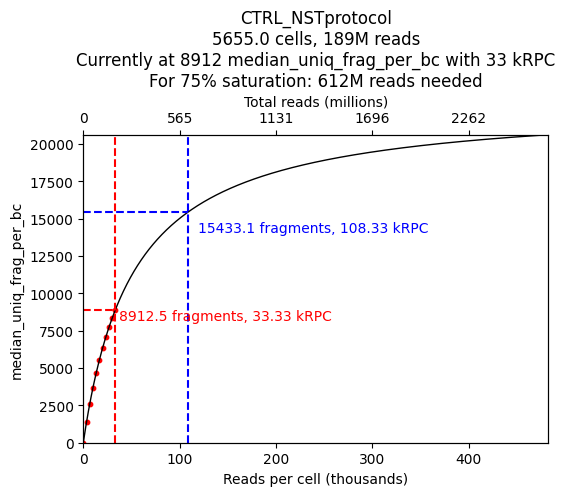

CTRL_NSTprotocol
5655.0 cells, 189M reads
Currently at 8912 median_uniq_frag_per_bc with 33 kRPC
For 75% saturation: 612M reads needed


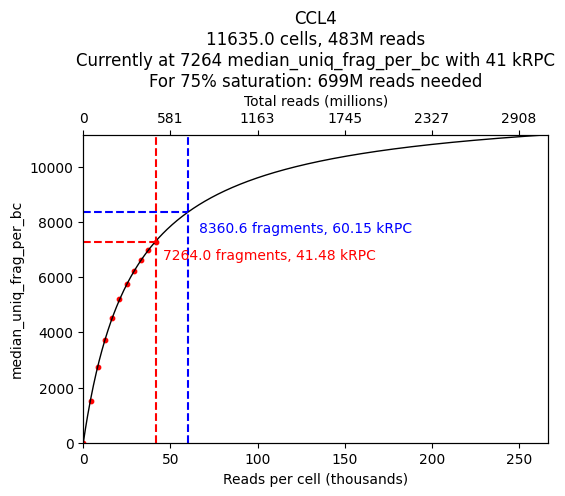

CCL4
11635.0 cells, 483M reads
Currently at 7264 median_uniq_frag_per_bc with 41 kRPC
For 75% saturation: 699M reads needed


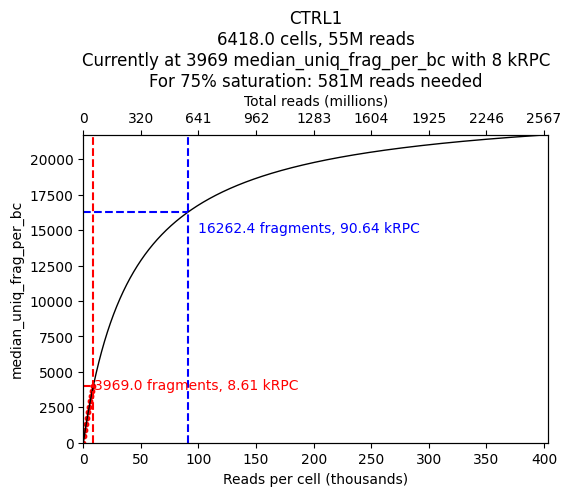

CTRL1
6418.0 cells, 55M reads
Currently at 3969 median_uniq_frag_per_bc with 8 kRPC
For 75% saturation: 581M reads needed


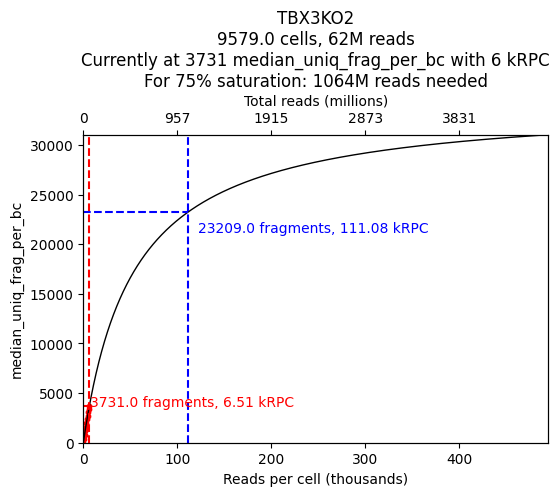

TBX3KO2
9579.0 cells, 62M reads
Currently at 3731 median_uniq_frag_per_bc with 6 kRPC
For 75% saturation: 1064M reads needed


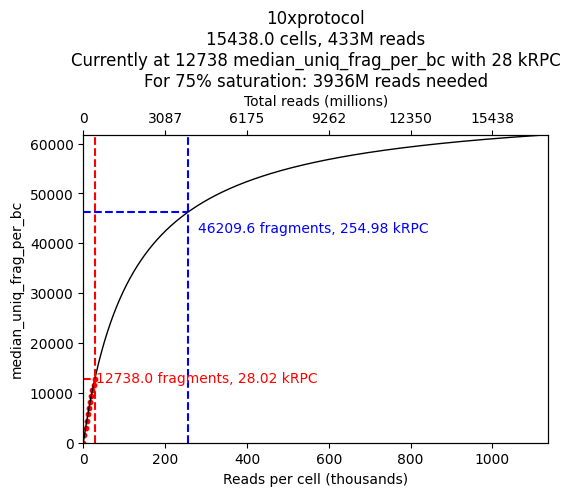

10xprotocol
15438.0 cells, 433M reads
Currently at 12738 median_uniq_frag_per_bc with 28 kRPC
For 75% saturation: 3936M reads needed


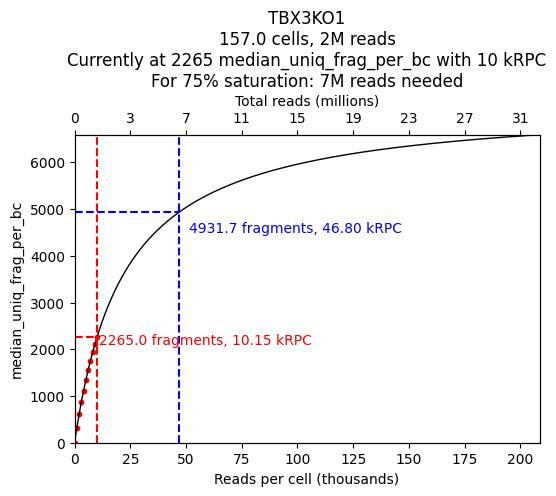

TBX3KO1
157.0 cells, 2M reads
Currently at 2265 median_uniq_frag_per_bc with 10 kRPC
For 75% saturation: 7M reads needed


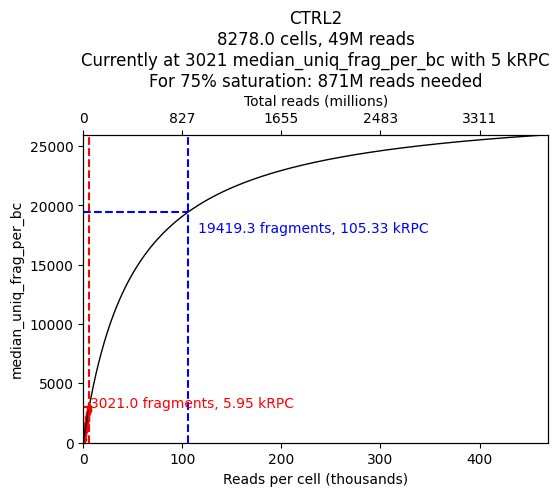

CTRL2
8278.0 cells, 49M reads
Currently at 3021 median_uniq_frag_per_bc with 5 kRPC
For 75% saturation: 871M reads needed


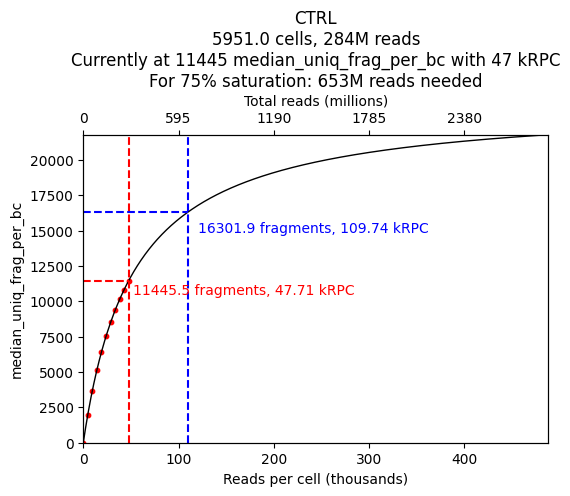

CTRL
5951.0 cells, 284M reads
Currently at 11445 median_uniq_frag_per_bc with 47 kRPC
For 75% saturation: 653M reads needed


In [49]:
for sample in fragments_paths_dict.keys():
    filepath = sampling_stats_path_dict[sample]
    n_reads = df_stats.at[sample, "n_reads"]
    n_cells = df_stats.at[sample, "n_cells"]

    pum.plot_saturation_fragments(
        filepath,
        sample_alias_dict[sample],
        n_reads,
        n_cells,
        x_axis="mean_reads_per_barcode",
        y_axis="median_uniq_frag_per_bc",
        function=MM,
        percentage_toplot=percentage_toplot,
        plot_current_saturation=True,
        svg_output_path=f"plots_qc/{sample}__fragments_saturation.svg",
        png_output_path=f"plots_qc/{sample}__fragments_saturation.png",
    )

Now, I want the duplication rate (fraction of fragments that are duplicates) on the y-axis instead. I also want to find the depth where 75% of reads are duplicates.

I use a michaelis-menten kinetic model with a maximum value fixed to 1 (number of duplicates cannot exceed 100%) to fit these values.

In [50]:
def MM_duplication(x, Km):
    """
    Define the Michaelis-Menten Kinetics model that will be used for the model fitting.
    """
    if Km > 0:
        y = x / (Km + x)
    else:
        y = 1e10
    return y

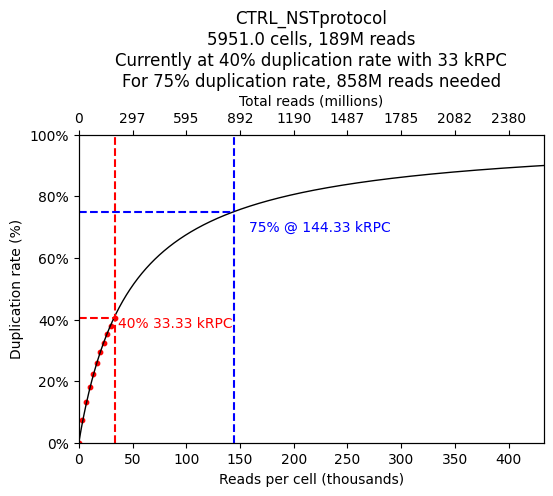

CTRL_NSTprotocol
5951.0 cells, 189M reads
Currently at 40% duplication rate with 33 kRPC
For 75% duplication rate, 858M reads needed


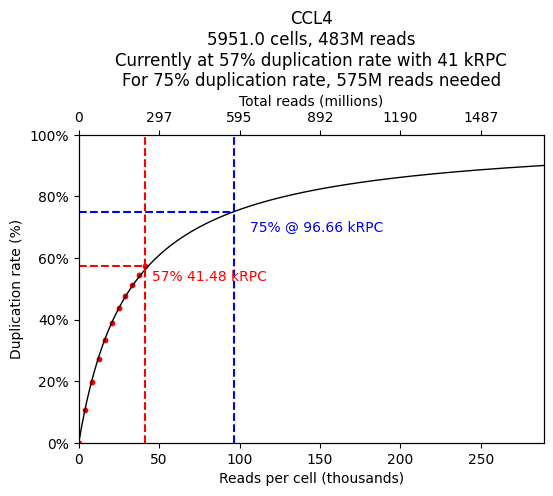

CCL4
5951.0 cells, 483M reads
Currently at 57% duplication rate with 41 kRPC
For 75% duplication rate, 575M reads needed


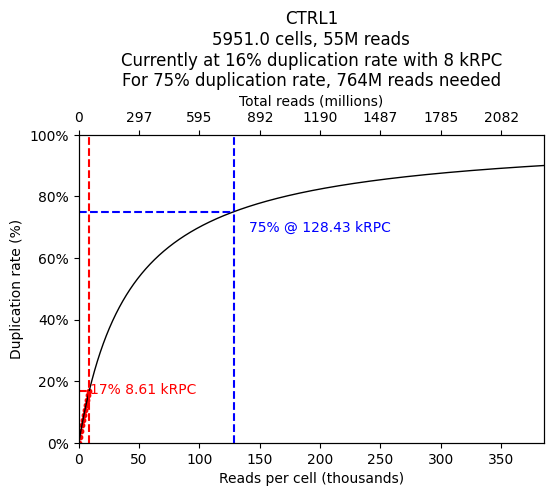

CTRL1
5951.0 cells, 55M reads
Currently at 16% duplication rate with 8 kRPC
For 75% duplication rate, 764M reads needed


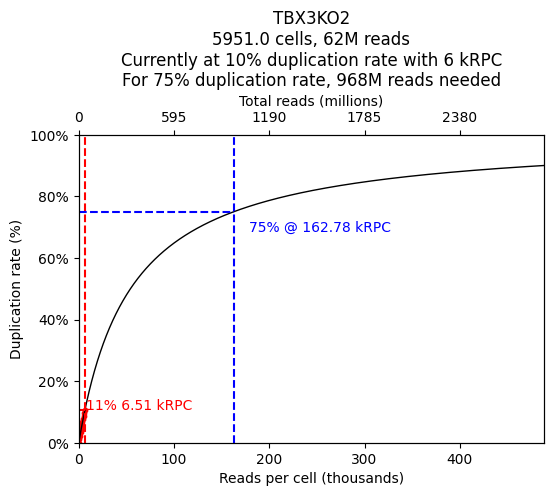

TBX3KO2
5951.0 cells, 62M reads
Currently at 10% duplication rate with 6 kRPC
For 75% duplication rate, 968M reads needed


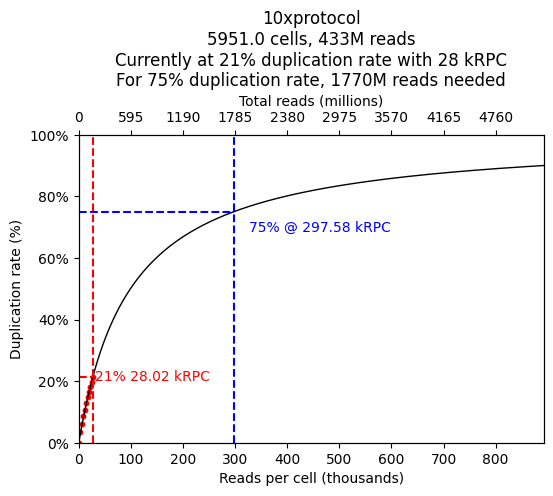

10xprotocol
5951.0 cells, 433M reads
Currently at 21% duplication rate with 28 kRPC
For 75% duplication rate, 1770M reads needed


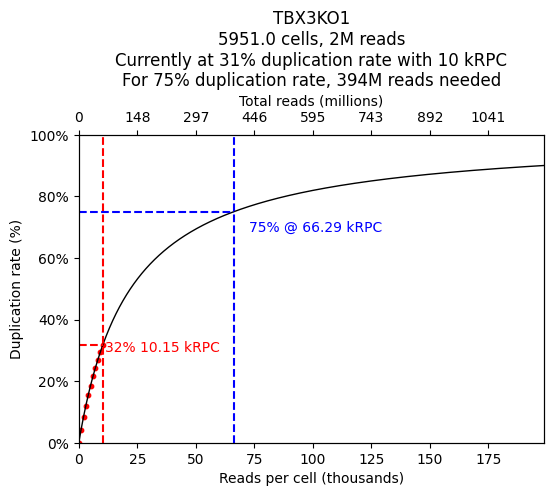

TBX3KO1
5951.0 cells, 2M reads
Currently at 31% duplication rate with 10 kRPC
For 75% duplication rate, 394M reads needed


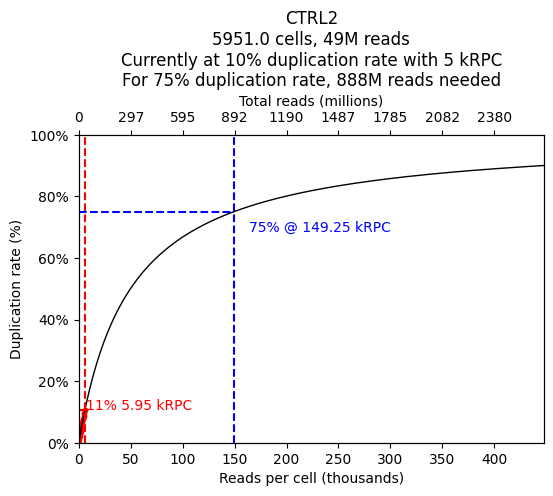

CTRL2
5951.0 cells, 49M reads
Currently at 10% duplication rate with 5 kRPC
For 75% duplication rate, 888M reads needed


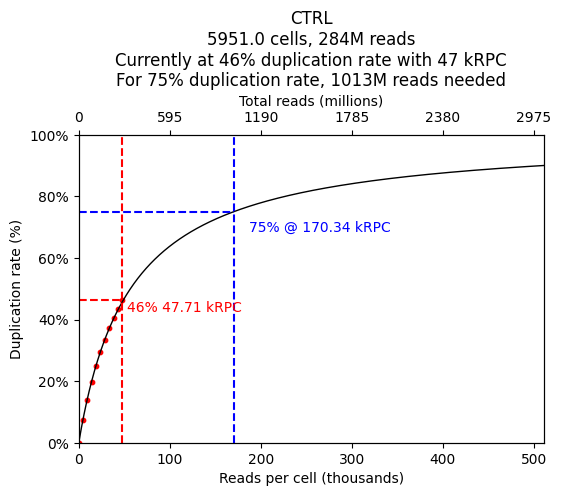

CTRL
5951.0 cells, 284M reads
Currently at 46% duplication rate with 47 kRPC
For 75% duplication rate, 1013M reads needed


In [51]:
for sample in fragments_paths_dict.keys():
    filepath = sampling_stats_path_dict[sample]
    n_reads = read_count_dict[sample]

    pum.plot_saturation_duplication(
        filepath,
        sample_alias_dict[sample],
        n_reads,
        n_cells,
        x_axis="mean_reads_per_barcode",
        y_axis="duplication_rate",
        function=MM_duplication,
        percentage_toplot=percentage_toplot,
        plot_current_saturation=True,
        svg_output_path=f"plots_qc/{sample}__duplication_saturation.svg",
        png_output_path=f"plots_qc/{sample}__duplication_saturation.png",
    )

# 4. Plot and compare to De Rop et al., 2023 benchmark

In [52]:
sns.set_context("notebook")
sns.set_style("darkgrid")

If you want, you can change the order in which your samples are plotted by manually editing key `user_sample` in the dictionary `order_dict_tech_ultrashort`

### 4a. Sequencing efficiency & Single-cell statistics

In [53]:
individual_barplot_width = 0.5
individual_plot_row_height = 4

In [54]:
tech_order = [
    "10xv1",
    "10xv11",
    "10xv11c",
    "10xv2",
    "10xmultiome",
    "user_sample",
    "mtscatac",
    "mtscatacfacs",
    "ddseq",
    "s3atac",
    "hydrop",
]

In [55]:
sample_order = [
    "TEW__043783__523d9c__Multiome_Liver_10xprotocol",
    "TEW__18d159__fe5107__Multiome_Liver_CCL4",
    "TEW__703a9e__28aa75__Multiome_Liver_CTRL",
    "TEW__72f3ec__1371a9__Multiome_Liver_TBX3KO1",
    "TEW__872466__dedf23__Multiome_Liver_CTRL1",
    "TEW__8e1858__1371a9__Multiome_Liver_TBX3KO2",
    "TEW__95843a__0f8200__Multiome_Liver_CTRL2",
    "TEW__ebb273__b33e6f__Multiome_Liver_CTRL_NSTprotocol",
]

In [56]:
ylim_dict = {
    "Unique_nr_frag_in_regions": [0, 20000],
    "Unique_nr_frag_in_regions_k": [0, 20],
    "FRIP": [0, 1],
    "TSS_enrichment": [0, 45],
}

In [57]:
individual_barplot_width = 0.5
individual_plot_row_height = 4

/lustre1/project/stg_00002/lcb/fderop/data/20230421_PUMATAC_tutorial_cellranger/pypumatac.py:1747: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


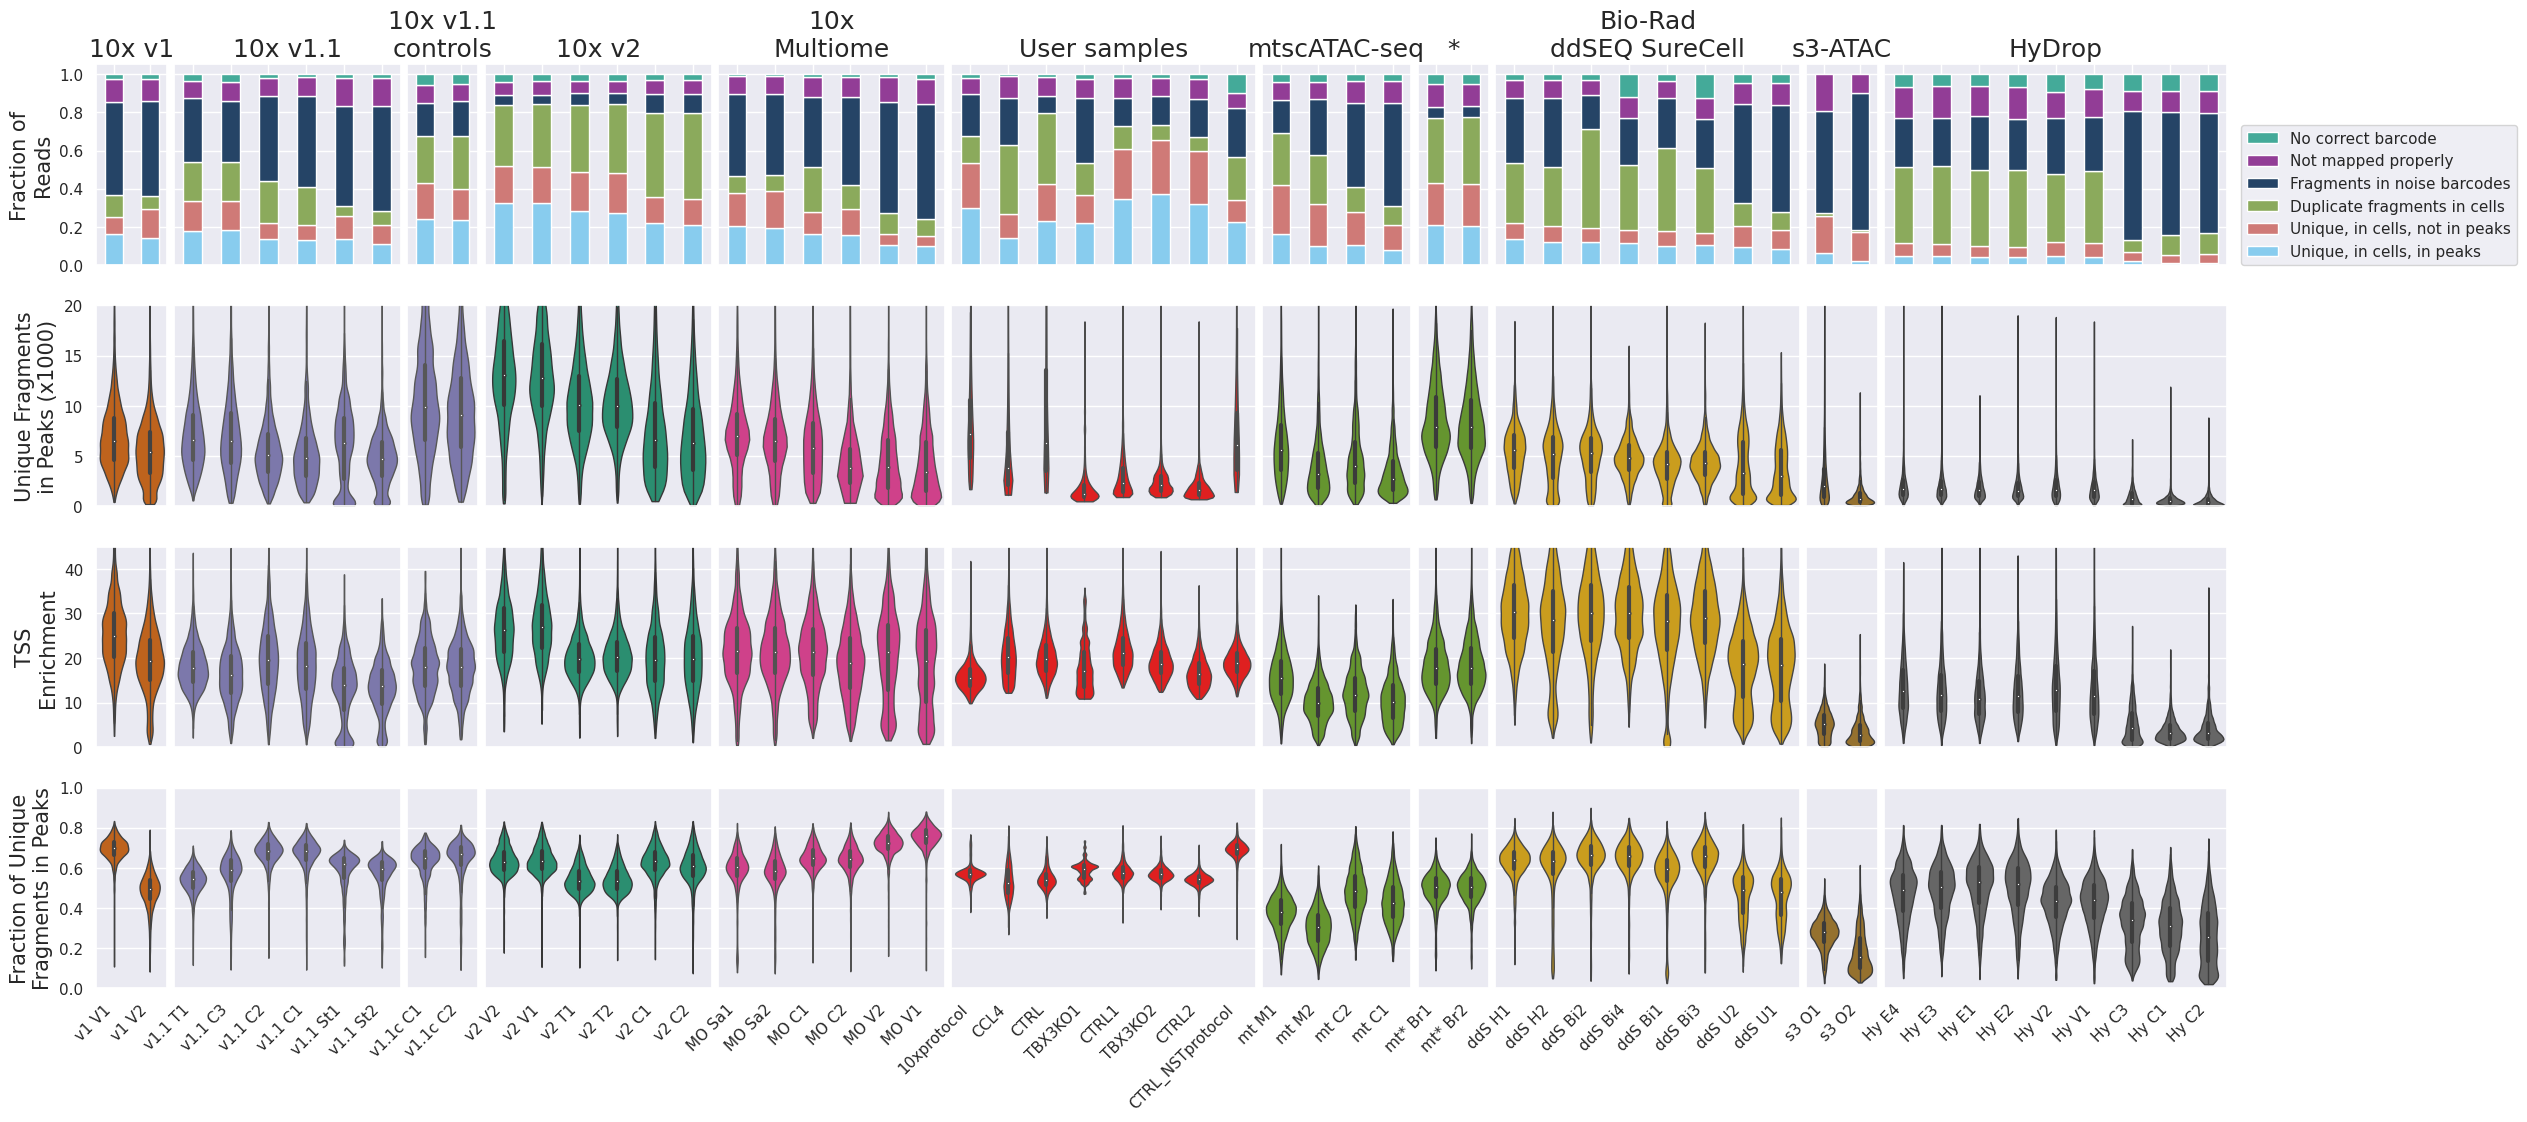

In [58]:
variables_list = ["Unique_nr_frag_in_regions_k", "TSS_enrichment", "FRIP"]

pum.plot_all_qc(
    df_stats_merged,
    df_scstats_merged,
    variables_list,
    sample_order,
    sample_alias_dict,
    tech_order,
    ylim_dict,
    svg_output_path="plots_qc/all_barplots.svg",
    png_output_path="plots_qc/all_barplots.png",
)

Only the user samples:

In [59]:
ymax_frags = (
    df_scstats_merged[df_scstats_merged["tech"] == "user_sample"]
    .groupby("sample_id")["Unique_nr_frag_in_regions"]
    .median()
    .max()
    * 2
)
ymax_frags_k = (
    df_scstats_merged[df_scstats_merged["tech"] == "user_sample"]
    .groupby("sample_id")["Unique_nr_frag_in_regions_k"]
    .median()
    .max()
    * 2
)
ymax_tss = (
    df_scstats_merged[df_scstats_merged["tech"] == "user_sample"]
    .groupby("sample_id")["TSS_enrichment"]
    .median()
    .max()
    * 2
)

ylim_dict = {
    "Unique_nr_frag_in_regions": [0, ymax_frags],
    "Unique_nr_frag_in_regions_k": [0, ymax_frags_k],
    "FRIP": [0, 1],
    "TSS_enrichment": [0, ymax_tss],
}

/lustre1/project/stg_00002/lcb/fderop/data/20230421_PUMATAC_tutorial_cellranger/pypumatac.py:1747: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


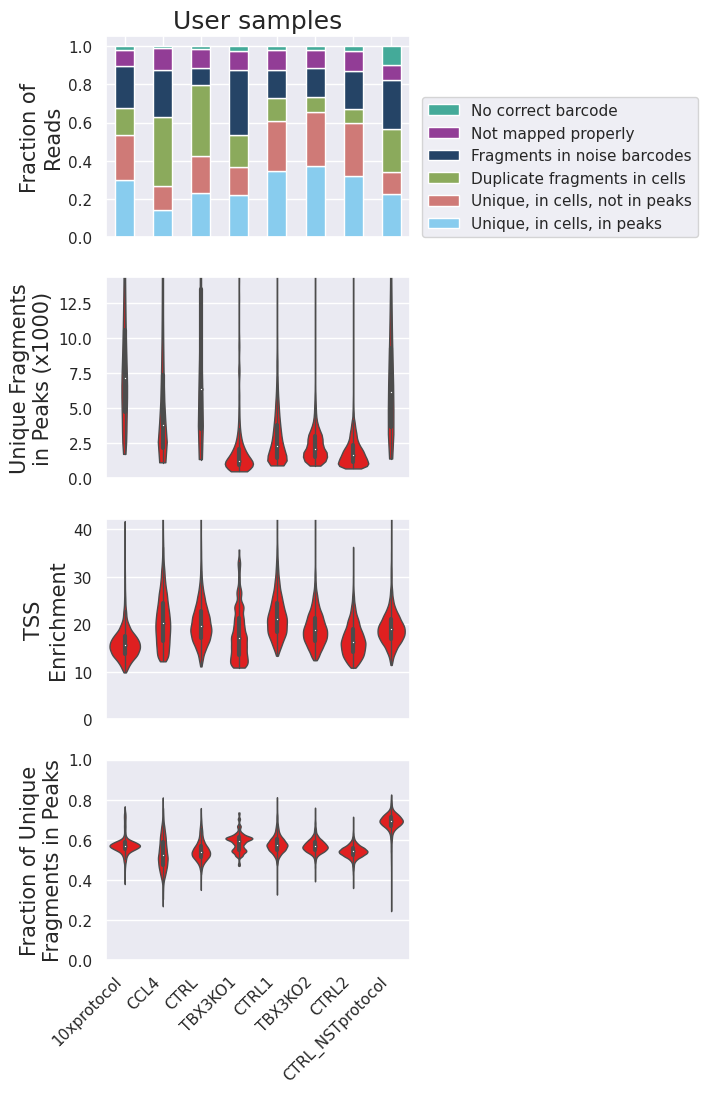

In [60]:
variables_list = ["Unique_nr_frag_in_regions_k", "TSS_enrichment", "FRIP"]

pum.plot_all_qc(
    df_stats_merged,
    df_scstats_merged,
    variables_list,
    sample_order,
    sample_alias_dict,
    ["user_sample"],
    ylim_dict,
    svg_output_path="plots_qc/usersamples_barplots.svg",
    png_output_path="plots_qc/usersamples_barplots.png",
)

### 4c. Sequencing-depth controlled statistics

Under construction